# Style Transfer Based Parkinson's EMG

Classical style transfer between 2 EMG signals

In [ ]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

In [18]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import pywt
import keras
from keras.utils import plot_model

In [19]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import Input, Dense, Flatten, Activation, Dropout, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D, GRU
from keras.layers import Add, Subtract, Multiply, ReLU, ThresholdedReLU, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAvgPool1D
from keras.layers.wrappers import Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D, UpSampling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
import tensorflow as tf

In [20]:
import sys
import datetime
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [8]:
path = './style_transfer_1d'
run_id = '/0010'
combined_path = path + run_id
pathlib.Path(combined_path).mkdir(parents=True, exist_ok=True) 
print(combined_path)

In [9]:
import json

configuration = {}

#Define parameters for data loading
configuration['data_filter'] = 1.0 #load only 100% of data        
configuration['channels'] = 1 #Number of channels
configuration['num_steps'] = 20000 # Number of time steps (40000 / 2.000 = 20s of data

# Define parameters for discriminator
configuration['activation_function'] = 'tanh'##''#'tanh'
configuration['moving_avg_window'] = 100

# Define parameters for wavelet decomposition
configuration['wavelet_mother'] = 'db7' 
configuration['wavelet_levels'] = 2
configuration['wavelet_trainable']=False

# Define parameters for generator               
configuration['seq_shape'] = (configuration['num_steps'], configuration['channels'])
configuration['sliding_window'] = 10

# Define parameters for training
configuration['dropout_rate'] = 0.2  # Dropout rate
configuration['epochs'] = 250

configuration_json_string = json.dumps(configuration)
with open(path + run_id + '/configuration.json', 'w') as file:
    file.write(configuration_json_string)

FileNotFoundError: [Errno 2] No such file or directory: './style_transfer_1d/0010/configuration.json'

In [10]:
def load_style():
    # Load data
    train_file_01 = "./data/pd_patient_1_emg.csv"
    
    #Loading EMG Signals - using only 1 signal for encoder-decoder approach
    x_series = ["FLEXOR_EMG_FILTERED"]

    X_1 = load_timeseries(train_file_03, x_series)

    X = pd.concat([X_1], axis=1)

    #Normalize data before hand
    X_values = X.values
    X_normalized, scalers = min_max(X_values,-1.0,1.0)
    #x values based on all variables
    data = X_normalized[0:configuration['num_steps']]
    #data_shape = int(math.sqrt(configuration['num_steps']))
    #data = np.reshape(data,(data_shape,data_shape,configuration['channels']))
    
    print('Loaded data shape: ' + str(data.shape))
    return data

def load_content():
    # Load data based on NINAPRO database reference
    train_file_01 = "./data/s01_stimulus_1.csv"
    train_file_02 = "./data/s01_stimulus_2.csv"
    train_file_03 = "./data/s01_stimulus_3.csv"
    
    #Loading EMG Signals - using only 1 signal for encoder-decoder approach
    x_series = ["EMG_03"]

    X_1 = load_timeseries(train_file_03, x_series)

    X = pd.concat([X_1], axis=1)

    #Normalize data before hand
    X_values = X.values
    X_normalized, scalers = min_max(X_values,-1.0,1.0)
    #x values based on all variables
    data = X_normalized[0:configuration['num_steps']]
    #data_shape = int(math.sqrt(configuration['num_steps']))
    #data = np.reshape(data,(data_shape,data_shape,configuration['channels']))
    
    print('Loaded data shape: ' + str(data.shape))
    return data

def load_timeseries(filename, series):
    #Load time series dataset
    loaded_series = pd.read_csv(filename, sep=',', header=0, index_col=0, squeeze=True)

    #Applying filter on the selected series
    selected_series = loaded_series.filter(items=series)

    return selected_series

def min_max(data, min, max):
    """Normalize data"""
    scaler = MinMaxScaler(feature_range=(min, max),copy=True)
    scaler.fit(data)
    norm_value = scaler.transform(data)
    return [norm_value, scaler]

def get_windows(data, window_size):
    # Split data into windows
    raw = []
    for index in range(len(data) - window_size):
        raw.append(data[index: index + window_size])
    return raw

def normalize(data):
    """Normalize data"""
    scaler = MinMaxScaler(feature_range=(0, 1),copy=True)
    scaler.fit(data)
    norm_value = scaler.transform(data)
    return [norm_value, scaler]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
#content_image=Image.open('./data/content.png')
#content_image=content_image.resize((512,512))
content_image = load_content()

Loaded data shape: (20000, 1)


In [12]:
#style_image= Image.open('./data/style.png')
#style_image=style_image.resize((512,512))
style_image = load_style()

Loaded data shape: (20000, 1)


In [10]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
#content_array=np.array(content_array).copy()

In [11]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)

(1, 20000, 1)
(1, 20000, 1)


In [12]:
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,configuration['num_steps'],configuration['channels']))

In [13]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
input_tensor.shape

TensorShape([Dimension(3), Dimension(20000), Dimension(1)])

Load the pre-trained model to be used as feature extraction

In [14]:
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

# From a PR that is not pulled into Keras
# https://github.com/fchollet/keras/pull/3677
# I updated the code to work on Keras 2.x

class MinibatchDiscrimination(Layer):
    """Concatenates to each sample information about how different the input
    features for that sample are from features of other samples in the same
    minibatch, as described in Salimans et. al. (2016). Useful for preventing
    GANs from collapsing to a single output. When using this layer, generated
    samples and reference samples should be in separate batches.

    # Example

    ```python
        # apply a convolution 1d of length 3 to a sequence with 10 timesteps,
        # with 64 output filters
        model = Sequential()
        model.add(Convolution1D(64, 3, border_mode='same', input_shape=(10, 32)))
        # now model.output_shape == (None, 10, 64)

        # flatten the output so it can be fed into a minibatch discrimination layer
        model.add(Flatten())
        # now model.output_shape == (None, 640)

        # add the minibatch discrimination layer
        model.add(MinibatchDiscrimination(5, 3))
        # now model.output_shape = (None, 645)
    ```

    # Arguments
        nb_kernels: Number of discrimination kernels to use
            (dimensionality concatenated to output).
        kernel_dim: The dimensionality of the space where closeness of samples
            is calculated.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        weights: list of numpy arrays to set as initial weights.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        input_dim: Number of channels/dimensions in the input.
            Either this argument or the keyword argument `input_shape`must be
            provided when using this layer as the first layer in a model.

    # Input shape
        2D tensor with shape: `(samples, input_dim)`.

    # Output shape
        2D tensor with shape: `(samples, input_dim + nb_kernels)`.

    # References
        - [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
    """

    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        # Set built to true.
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
def make_wavelet_expansion(input_tensor):
    low_pass, high_pass  = pywt.Wavelet(configuration['wavelet_mother']).filter_bank[:2]
    low_pass_filter = np.array(low_pass)
    high_pass_filter = np.array(high_pass)
    n_levels = configuration['wavelet_levels']
    trainable = configuration['wavelet_trainable']
    
    wv_kwargs = {
        "filters":1,
        "kernel_size":len(low_pass),
        "strides":2,     
        "use_bias":False, 
        "padding":"same", 
        "trainable":trainable,
    }

    approximation_coefficients = []
    detail_coefficients = []

    last_approximant = input_tensor
    for i in range(n_levels):
        lpf = low_pass_filter
        hpf = high_pass_filter
        a_n = Conv1D(
            kernel_initializer=keras.initializers.Constant(lpf.reshape((-1, 1))),
            name="low_pass_{}".format(i),
            **wv_kwargs
        )(last_approximant)
        d_n = Conv1D(
            kernel_initializer=keras.initializers.Constant(hpf.reshape((-1, 1))),
            name="high_pass_{}".format(i),
            **wv_kwargs,
        )(last_approximant)

        detail_coefficients.append(d_n)
        approximation_coefficients.append(a_n)
        last_approximant = a_n

    return approximation_coefficients, detail_coefficients
    
def envelopes(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    input_ = args
    abs_envelope = backend.abs(input_)
    envelope = tf.contrib.signal.frame(
        input_,
        configuration['moving_avg_window'],
        1,#steps
        pad_end=True,
        pad_value=0,
        axis=1,
        name='envelope_moving_average'
    )
    envelope_reshaped = backend.reshape(envelope,(-1,backend.shape(input_)[1],configuration['moving_avg_window']))
    print('Envelope: ' + str(envelope))
    print('Envelope_reshaped: ' + str(envelope_reshaped))
    envelope_mean = backend.mean(envelope_reshaped, axis=2, keepdims=True)
    print('Envelope Mean: ' + str(envelope_mean))
    return envelope_mean

def diff_op(self, args):
    a = args
    diff_tensor = a[:,1:]-a[:,:-1]
    return diff_tensor
    
def build_critic(input_tensor):

    if(input_tensor == -1):
        input_ = Input(shape=(2000,1))
        shape_ = (2000,1)
    else:
        input_ = Input(tensor = input_tensor)
        shape_ = configuration['seq_shape']
    
    #CNN on raw signal
    cnn_1 = Lambda(self.diff_op, output_shape=self.seq_shape, name='diff_op')(input_) #including moving average at the end
    cnn_1 = Conv1D(16, kernel_size=3, strides=2, input_shape=configuration['seq_shape'], padding="same")(cnn_1)
    cnn_1 = LeakyReLU(alpha=0.2)(cnn_1)
    cnn_1 = Dropout(configuration['dropout_rate'])(cnn_1)
    cnn_2 = Conv1D(32, kernel_size=3, strides=2, padding="same")(cnn_1)
    cnn_2 = BatchNormalization(momentum=0.8)(cnn_2)
    cnn_2 = LeakyReLU(alpha=0.2)(cnn_2)
    cnn_2 = Dropout(configuration['dropout_rate'])(cnn_2)
    cnn_3 = Conv1D(64, kernel_size=3, strides=2, padding="same")(cnn_2)
    cnn_3 = BatchNormalization(momentum=0.8)(cnn_3)
    cnn_3 = LeakyReLU(alpha=0.2)(cnn_3)
    cnn_3 = Dropout(configuration['dropout_rate'])(cnn_3)
    cnn_4 = Conv1D(32, kernel_size=3, strides=2, padding="same")(cnn_3)
    cnn_4 = BatchNormalization(momentum=0.8)(cnn_4)
    cnn_4 = LeakyReLU(alpha=0.2)(cnn_4)
    cnn_4 = Dropout(configuration['dropout_rate'])(cnn_4)
    cnn_4 = Flatten()(cnn_4)
    
    #CNN on FFT of raw signal
    fft = Flatten()(input_)
    fft = Lambda(tf.spectral.rfft)(fft)
    fft_abs = Lambda(backend.abs)(fft)
    fft_abs = Reshape((-1,1))(fft_abs)
    fft_cnn_1 = Conv1D(16, kernel_size=3, strides=2, input_shape=configuration['seq_shape'], padding="same")(fft_abs)
    fft_cnn_1 = LeakyReLU(alpha=0.2)(fft_cnn_1)
    fft_cnn_1 = Dropout(configuration['dropout_rate'])(fft_cnn_1)
    fft_cnn_2 = Conv1D(32, kernel_size=3, strides=2, padding="same")(fft_cnn_1)
    fft_cnn_2 = BatchNormalization(momentum=0.8)(fft_cnn_2)
    fft_cnn_2 = LeakyReLU(alpha=0.2)(fft_cnn_2)
    fft_cnn_2 = Dropout(configuration['dropout_rate'])(fft_cnn_2)
    fft_cnn_3 = Conv1D(64, kernel_size=3, strides=2, padding="same")(fft_cnn_2)
    fft_cnn_3 = BatchNormalization(momentum=0.8)(fft_cnn_3)
    fft_cnn_3 = LeakyReLU(alpha=0.2)(fft_cnn_3)
    fft_cnn_3 = Dropout(configuration['dropout_rate'])(fft_cnn_3)
    fft_cnn_4 = Conv1D(64, kernel_size=3, strides=2, padding="same")(fft_cnn_3)
    fft_cnn_4 = BatchNormalization(momentum=0.8)(fft_cnn_4)
    fft_cnn_4 = LeakyReLU(alpha=0.2)(fft_cnn_4)
    fft_cnn_4 = Dropout(configuration['dropout_rate'])(fft_cnn_4)        
    fft_cnn_4 = Flatten()(fft_cnn_4)
            
    #CNN on FFT of envelope
    envelope_window = Lambda(envelopes, output_shape=shape_, name='envelope')(input_)
    envelope_window = Flatten()(envelope_window)
    envelope_fft = Lambda(tf.spectral.rfft)(envelope_window)
    envelope_fft_abs = Lambda(backend.abs)(envelope_fft)
    envelope_fft_abs = Reshape((-1,1))(envelope_fft_abs)
    envelope_cnn_1 = Conv1D(16, kernel_size=3, strides=2, input_shape=configuration['seq_shape'], padding="same")(envelope_fft_abs)
    envelope_cnn_1 = LeakyReLU(alpha=0.2)(envelope_cnn_1)
    envelope_cnn_1 = Dropout(configuration['dropout_rate'])(envelope_cnn_1)
    envelope_cnn_2 = Conv1D(32, kernel_size=3, strides=2, padding="same")(envelope_cnn_1)
    envelope_cnn_2 = BatchNormalization(momentum=0.8)(envelope_cnn_2)
    envelope_cnn_2 = LeakyReLU(alpha=0.2)(envelope_cnn_2)
    envelope_cnn_2 = Dropout(configuration['dropout_rate'])(envelope_cnn_2)
    envelope_cnn_3 = Conv1D(64, kernel_size=3, strides=2, padding="same")(envelope_cnn_2)
    envelope_cnn_3 = BatchNormalization(momentum=0.8)(envelope_cnn_3)
    envelope_cnn_3 = LeakyReLU(alpha=0.2)(envelope_cnn_3)
    envelope_cnn_3 = Dropout(configuration['dropout_rate'])(envelope_cnn_3)
    envelope_cnn_4 = Conv1D(64, kernel_size=3, strides=2, padding="same")(envelope_cnn_3)
    envelope_cnn_4 = BatchNormalization(momentum=0.8)(envelope_cnn_4)
    envelope_cnn_4 = LeakyReLU(alpha=0.2)(envelope_cnn_4)
    envelope_cnn_4 = Dropout(configuration['dropout_rate'])(envelope_cnn_4)
    envelope_cnn_4 = Flatten()(envelope_cnn_4)
    
    # Wavelet Expansion
    approx_stack, detail_stack = make_wavelet_expansion(input_)
    features_list = []
    features_list.extend(detail_stack)
    features_list.append(approx_stack[-1])
    wavelet_concatenate = Concatenate(axis=1)(features_list)
    wavelet_cnn_1 = Conv1D(16, kernel_size=3, strides=2, input_shape=configuration['seq_shape'], padding="same")(wavelet_concatenate)
    wavelet_cnn_1 = LeakyReLU(alpha=0.2)(wavelet_cnn_1)
    wavelet_cnn_1 = Dropout(configuration['dropout_rate'])(wavelet_cnn_1)
    wavelet_cnn_2 = Conv1D(32, kernel_size=3, strides=2, padding="same")(wavelet_cnn_1)
    wavelet_cnn_2 = BatchNormalization(momentum=0.8)(wavelet_cnn_2)
    wavelet_cnn_2 = LeakyReLU(alpha=0.2)(wavelet_cnn_2)
    wavelet_cnn_2 = Dropout(configuration['dropout_rate'])(wavelet_cnn_2)
    wavelet_cnn_3 = Conv1D(64, kernel_size=3, strides=2, padding="same")(wavelet_cnn_2)
    wavelet_cnn_3 = BatchNormalization(momentum=0.8)(wavelet_cnn_3)
    wavelet_cnn_3 = LeakyReLU(alpha=0.2)(wavelet_cnn_3)
    wavelet_cnn_3 = Dropout(configuration['dropout_rate'])(wavelet_cnn_3)
    wavelet_cnn_4 = Conv1D(32, kernel_size=3, strides=2, padding="same")(wavelet_cnn_3)
    wavelet_cnn_4 = BatchNormalization(momentum=0.8)(wavelet_cnn_4)
    wavelet_cnn_4 = LeakyReLU(alpha=0.2)(wavelet_cnn_4)
    wavelet_cnn_4 = Dropout(configuration['dropout_rate'])(wavelet_cnn_4)
    wavelet_cnn_4 = Flatten()(wavelet_cnn_4)        
    
    # Mini batch discrimination
    mini_disc = Flatten()(input_)
    mini_disc = MinibatchDiscrimination(10,3)(mini_disc)
    # now model.output_shape = (None, 645)
               
    concatenate = Concatenate()([cnn_4,fft_cnn_4,envelope_cnn_4,wavelet_cnn_4,mini_disc])
    mlp = Dense(1,activation='sigmoid')(concatenate)
            
    model = Model(input_, mlp)
    
    print('Critic model:')
    model.summary()
    #model_json = model.to_json()
    #with open(path + '/critic.json', "w") as json_file:
    #    json_file.write(model_json)
    file_name = combined_path + '/critic.png'
    plot_model(model, to_file=file_name, show_shapes = True)
    
    return model

def save_critic(index=-1):
    if index == -1:
        file_path = combined_path + '/critic.h5'
    else:
        file_path = combined_path + '/critic_' + str(index) + '.h5'
    self.critic.save_weights(file_path)

def load_critic(index=-1):
    if index == -1:
        file_path = path + '/critic.h5'
    else:
        file_path = path + '/critic_' + str(index) + '.h5'
    self.critic = self.build_critic()
    self.critic.load_weights(file_path)

In [16]:
#model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
model = build_critic(-1)
file_path = path + '/critic.h5'
model.load_weights(file_path)

new_model = build_critic(input_tensor)

for i in range(0, len(model.layers)-3):
    weight = model.layers[i].get_weights()
    new_model.layers[i].set_weights(weight)

model = new_model

Envelope: Tensor("envelope/envelope_moving_average/Reshape_4:0", shape=(?, 2000, 100, 1), dtype=float32)
Envelope_reshaped: Tensor("envelope/Reshape:0", shape=(?, ?, 100), dtype=float32)
Envelope Mean: Tensor("envelope/Mean:0", shape=(?, ?, 1), dtype=float32)
Critic model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000, 1)      0                                            
__________________________________________________________________________________________________
envelope (Lambda)               (None, 2000, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2000)         0           input_1[0][0]                    
_________________________________

Envelope: Tensor("envelope_1/envelope_moving_average/Reshape_4:0", shape=(3, 20000, 100, 1), dtype=float32)
Envelope_reshaped: Tensor("envelope_1/Reshape:0", shape=(3, 20000, 100), dtype=float32)
Envelope Mean: Tensor("envelope_1/Mean:0", shape=(3, 20000, 1), dtype=float32)
Critic model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (3, 20000, 1)        0                                            
__________________________________________________________________________________________________
envelope (Lambda)               (3, 20000, 1)        0           input_2[0][0]                    
__________________________________________________________________________________________________
flatten_9 (Flatten)             (3, 20000)           0           input_2[0][0]                    
__________________

Set the #content_weight and #style_weight according to desired influence of content or style on the output signal

In [18]:
content_weight = 0.1
style_weight = 5.0
total_variation_weight = 0.0

In [19]:
layers=dict([(layer.name, layer.output) for layer in model.layers])

In [20]:
loss=backend.variable(0.)

In [30]:
#Define loss functions
def emg_dynamic_loss(y_true, y_pred):
    m_factor = tf.constant(20.0)
    delta = tf.constant(0.05)
    abs_tensor = K.abs(y_true)
    diff_abs = K.abs(y_true - y_pred)
    mask = tf.math.greater_equal(abs_tensor, delta) # boolean tensor, mask[i] = True iff x[i] > 1
    bigger = tf.boolean_mask(diff_abs, mask)
    m = tf.multiply(bigger, m_factor)
    loss = K.mean(m) # mean amplified loss for "moving" part of signal
    return loss
    
def emg_static_loss(y_true, y_pred):
    m_factor = tf.constant(20.0)
    delta = tf.constant(0.05)
    abs_tensor = backend.abs(y_true)
    diff_abs = backend.abs(y_true - y_pred)
    mask = tf.math.less_equal(abs_tensor, delta) # boolean tensor, mask[i] = True iff x[i] > 1
    bigger = tf.boolean_mask(diff_abs, mask)
    m = tf.multiply(bigger, m_factor)
    loss = backend.mean(m) # mean amplified loss for "static" part of signal
    return loss

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=1
    size=configuration['num_steps']
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

def content_loss(content, combination):
    cl = backend.mean(backend.square(content-combination)) + emg_dynamic_loss(content,combination)
    return cl

def diff_loss(content, combination):
    content_diff = content[1:]-content[:-1]
    combination_diff = combination[1:]-combination[:-1]
    dl = backend.sum(backend.square(content_diff - combination_diff))
    return dl

# Definition of feature layers for the content loss

In [32]:
#Definition of content layers to apply content loss
#layer_features=layers['block2_conv2']
#layer_features=layers['conv1d_18']
layer_features=layers['input_2']
content_image_features=layer_features[0,:,:]
style_features=layer_features[1,:,:]
combination_features=layer_features[2,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

Gram matrix between the features

In [33]:
def gram_matrix(x):
    features=backend.batch_flatten(x)
    gram=backend.dot(features, backend.transpose(features))
    return gram

# Definition of feature layers for the style loss

In [34]:
#Definition of style layers
#feature_layers = ['block1_conv2', 'block2_conv2',
#                  'block3_conv3', 'block4_conv3',
#                  'block5_conv3']
feature_layers = ['conv1d_20', 'conv1d_24',
                  'conv1d_28', 'conv1d_32']

In [35]:
#Adding Style Loss
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:]
    #style_features = backend.reshape(style_features,(style_features.shape[0],style_features.shape[1],1))
    print(style_features.shape)
    combination_features=layer_features[2,:,:]    
    #combination_features = backend.reshape(combination_features,(style_features.shape[0],style_features.shape[1],1))
    print(combination_features.shape)
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

(1250, 32)
(1250, 32)
(626, 64)
(626, 64)
(626, 64)
(626, 64)
(1250, 32)
(1250, 32)


In [36]:
#Adding total variation loss - if you want to add a loss between the a diff function of the input and reference signals
loss += total_variation_weight * diff_loss(style_features, combination_features)

In [37]:
grads = backend.gradients(loss, combination_image)

In [38]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [39]:
def eval_loss_and_grads(x):
    x = x.reshape((1, configuration['num_steps'], 1))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [40]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [41]:
from dtaidistance import dtw
from scipy import signal
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

#Define metrics
def dtw_distance(y_true, y_pred):        
    #distance = dtw.distance(y_true, y_pred)
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    return distance

def loss_fft(y_true, y_pred):        
    fft_true = np.abs(np.fft.rfft(y_true))
    #print('FFT Shape: {}'.format(fft_true.shape))
    fft_pred = np.abs(np.fft.rfft(y_pred))
    #print('FFT Shape: {}'.format(fft_pred.shape))
    loss = np.mean(np.square(np.subtract(fft_true,fft_pred))) #calculate mse from fft
    #print('FFT Shape: {}'.format(loss.shape))
    #fft_all = np.concatenate((fft_true,fft_pred,loss),axis=0)
    return loss, fft_true, fft_pred

def cross_correlation(y_true, y_pred):
    cc = np.correlate(y_true,y_pred)
    return cc

In [2]:
def plot_signal(signal, title, file):
    x = np.linspace(0, len(signal) / 2000.0, num=len(signal))
    plt.figure()
    axes = plt.gca()
    axes.set_ylim([-1.0,1.0])
    plt.plot(x,signal[:], label=title)
    plt.xlabel('Time')
    plt.ylabel('EMG')
    plt.legend()
    plt.savefig(combined_path + file)
    plt.show()
    plt.close()
    
def plot_metrics(epoch, metrics, ffts):
    
    metrics_np = np.array(metrics)
    
    plt.figure()
    axes = plt.gca()
    axes.set_ylim([0,100])
    plt.plot(metrics_np[:,0], label='Total Loss')
    plt.title('Style Transfer Loss (content + style)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Metric')
    plt.legend()
    plt.savefig(combined_path + '/Losses_{}.png'.format(epoch))
    plt.show()
    plt.close()
    
    plt.figure()
    axes = plt.gca()
    axes.set_ylim([0,200])   
    plt.plot(metrics_np[:,2], label='FFT MSE Generated vs Content')
    plt.plot(metrics_np[:,5], label='FFT MSE Generated vs Style')
    plt.title('FFT MSE')
    plt.xlabel('Epoch')
    plt.ylabel('FFT MSE')
    plt.legend()
    plt.savefig(combined_path + '/FFT_mse_{}.png'.format(epoch))
    plt.show()
    plt.close()    
            
    plt.figure()
    axes = plt.gca()
    axes.set_ylim([0,200])   
    plt.plot(ffts[2], label='FFT Generated')
    plt.plot(ffts[0], label='FFT Content')
    plt.title('FFT of Generated Signal vs FFT of Content Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('FFT')
    plt.legend()
    plt.savefig(combined_path + '/FFT_content_{}.png'.format(epoch))
    plt.show()
    plt.close()
    
    plt.figure()       
    axes = plt.gca()
    axes.set_ylim([0,200])    
    plt.plot(ffts[2], label='FFT Generated')
    plt.plot(ffts[1], label='FFT Style')
    plt.title('FFT of Generated Signal vs FFT of Style Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('FFT')
    plt.legend()
    plt.savefig(combined_path + '/FFT_style_{}.png'.format(epoch))
    plt.show()
    plt.close()
    
    plt.figure()       
    axes = plt.gca()
    #axes.set_ylim([0,100])    
    plt.plot(metrics_np[:,4], label='Cross-correlation Generated vs Style')
    plt.plot(metrics_np[:,1], label='Cross-correlation Generated vs Content')
    plt.title('Cross Correlation')
    plt.xlabel('Epoch')
    plt.ylabel('FFT Convolve')
    plt.legend()
    plt.savefig(combined_path + '/FFT_convolve_{}.png'.format(epoch))
    plt.show()
    plt.close()
    
    plt.figure()       
    axes = plt.gca()
    #axes.set_ylim([0,100])    
    plt.plot(metrics_np[:,6], label='DTW Generated vs Style')
    plt.plot(metrics_np[:,3], label='DTW Generated vs Content')
    plt.title('DTW Distance')
    plt.xlabel('Epoch')
    plt.ylabel('DTW')
    plt.legend()
    plt.savefig(combined_path + '/DTW_{}.png'.format(epoch))
    plt.show()
    plt.close()

In [43]:
evaluator=Evaluator()

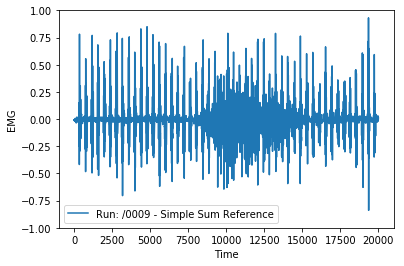

In [44]:
#Calculate and plot the simple sum of content and style
simple_sum = np.add(style_array.flatten(),content_array.flatten())
plot_signal(simple_sum, 'Run: {0} - Simple Sum Reference'.format(run_id), "simple_sum.png")

In [45]:
#Start with content as initial guess
x=np.reshape(content_array.flatten(),(1,configuration['num_steps'],1))

# ALternatively, start with the simple sum of the content and the style signal as initial guess
#x=np.reshape(simple_sum,(1,configuration['num_steps'],1))

iterations = 100 #every iteration = 10 epoch, so we use 500 iterations to complete 5000 epochs

Start of iteration 50
Total loss: 6.060754776000977
Iteration 50 completed in 0s


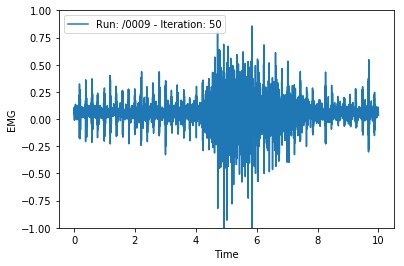

Metrics - Content CC:[170.28374039], FFT:151.04255067909656, DTW:1229.6543022953365
Metrics - Style CC:[-49.9266289], FFT:116.21625897246054, DTW:2409.572423828622


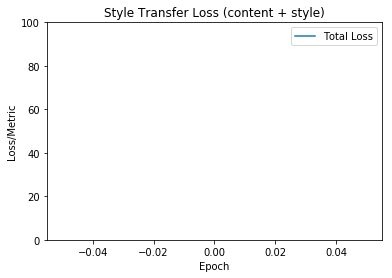

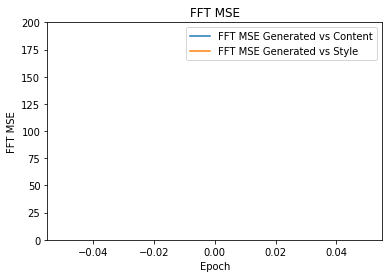

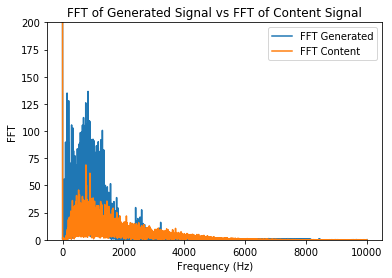

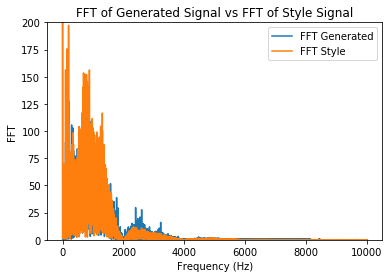

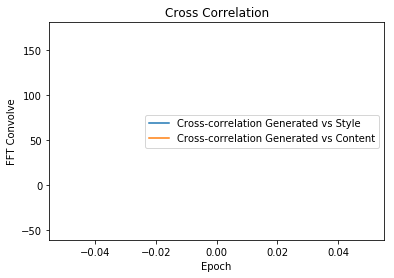

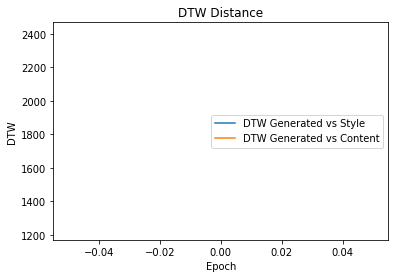

Start of iteration 51
Total loss: 6.020620346069336
Iteration 51 completed in 0s


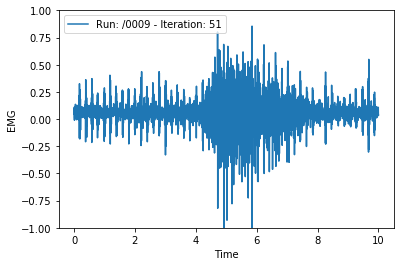

Metrics - Content CC:[170.1441335], FFT:151.20895572828059, DTW:1231.184627714742
Metrics - Style CC:[-49.63810737], FFT:116.16244207581013, DTW:2420.4198691034753


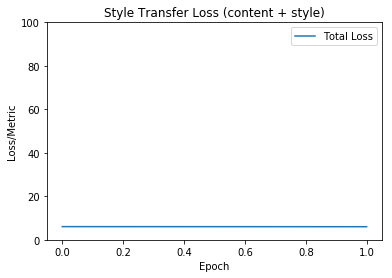

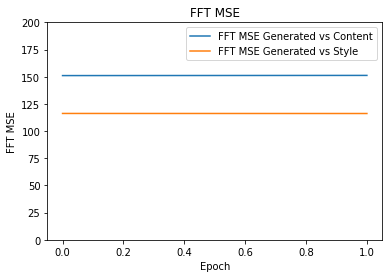

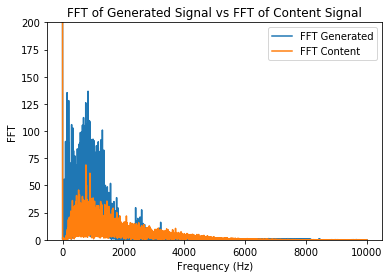

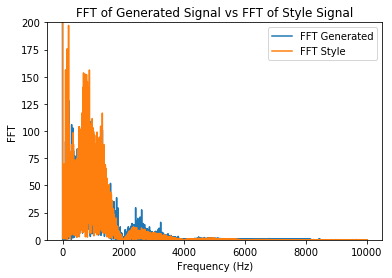

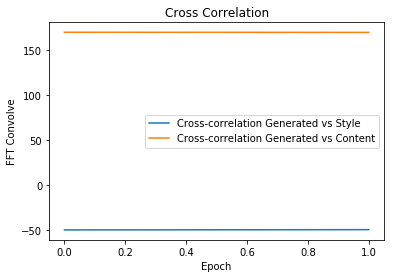

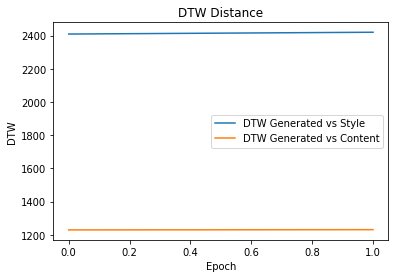

Start of iteration 52
Total loss: 5.965296268463135
Iteration 52 completed in 0s


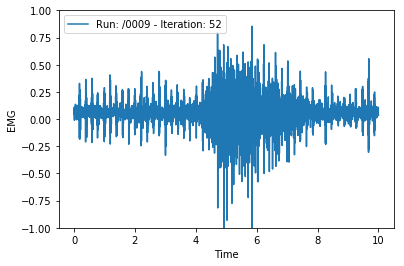

Metrics - Content CC:[169.86930818], FFT:151.44036992666668, DTW:1227.6103907201696
Metrics - Style CC:[-49.13447616], FFT:116.07920420444457, DTW:2416.8577427411947


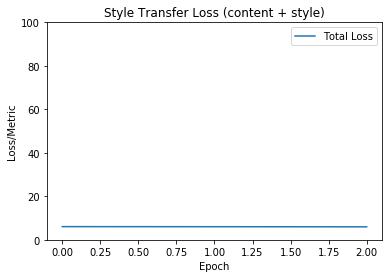

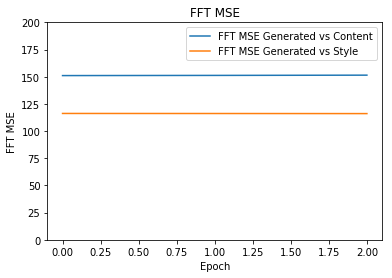

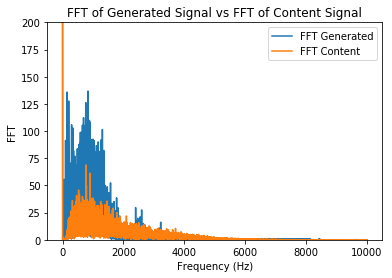

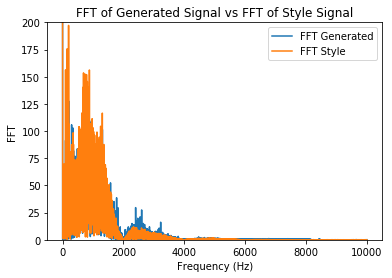

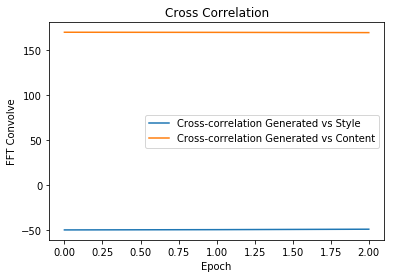

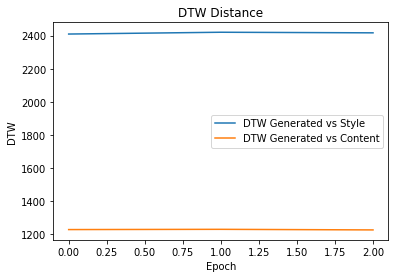

Start of iteration 53
Total loss: 5.916593551635742
Iteration 53 completed in 0s


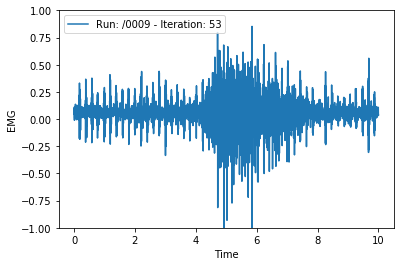

Metrics - Content CC:[169.72747701], FFT:151.70320008044803, DTW:1228.1500197224034
Metrics - Style CC:[-48.7964092], FFT:116.01758204976733, DTW:2415.996727470698


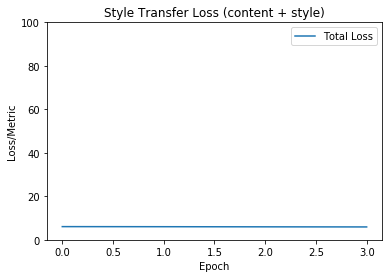

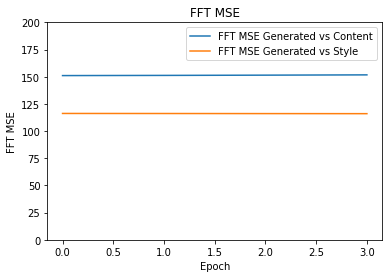

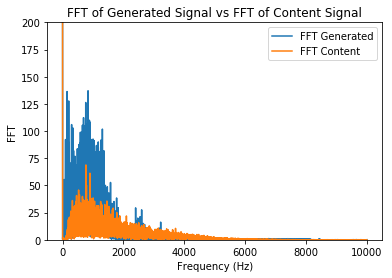

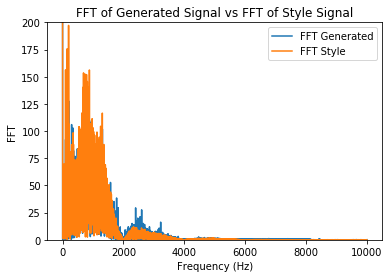

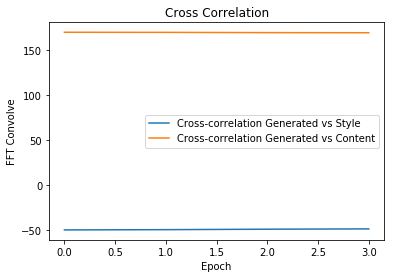

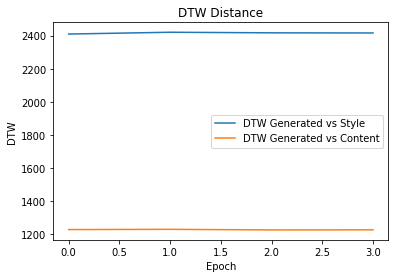

Start of iteration 54
Total loss: 5.877563953399658
Iteration 54 completed in 0s


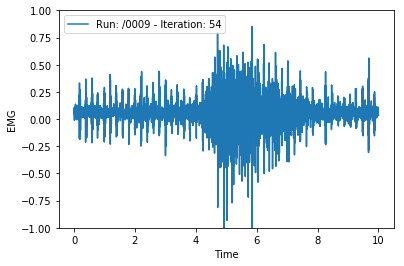

Metrics - Content CC:[169.60280753], FFT:151.7668301645389, DTW:1228.737854940049
Metrics - Style CC:[-48.59512335], FFT:115.98512236535282, DTW:2416.363758311966


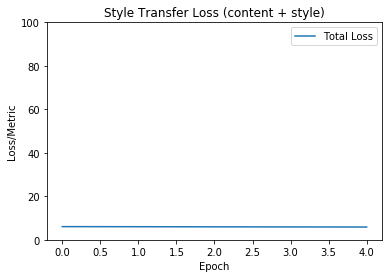

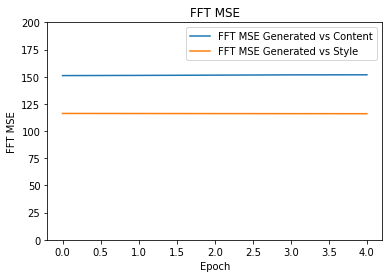

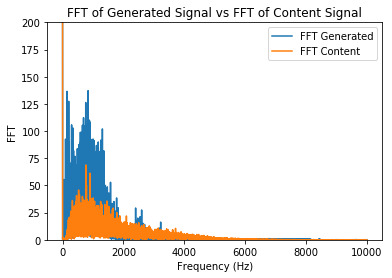

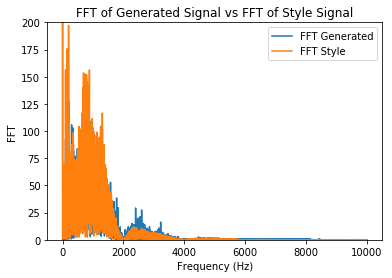

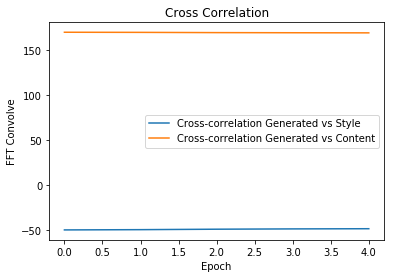

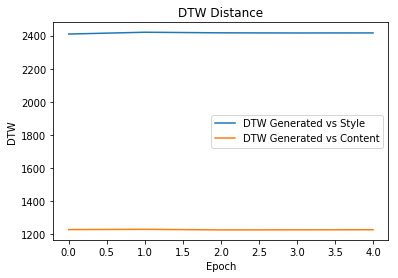

Start of iteration 55
Total loss: 5.834301471710205
Iteration 55 completed in 0s


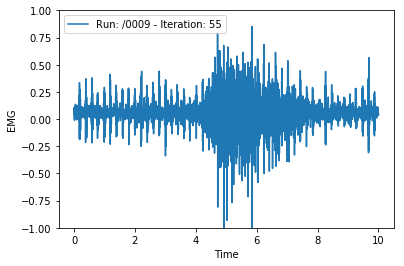

Metrics - Content CC:[169.41900135], FFT:151.99303904764804, DTW:1278.070932560862
Metrics - Style CC:[-48.20636539], FFT:115.91084121203619, DTW:2423.592806531524


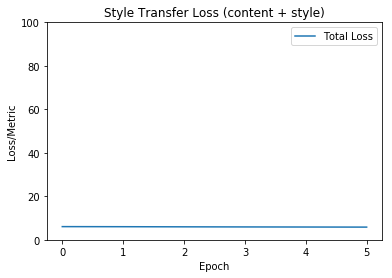

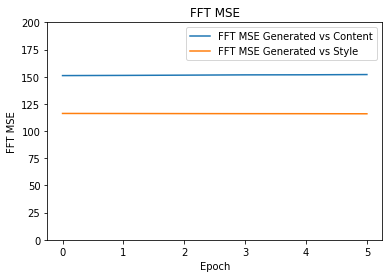

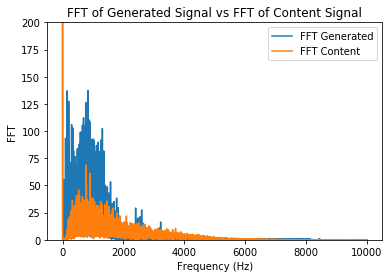

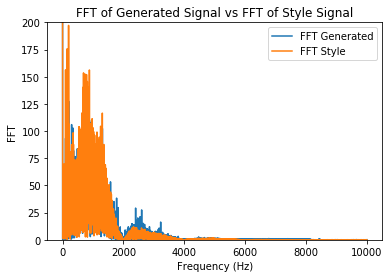

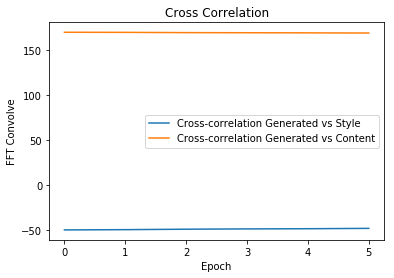

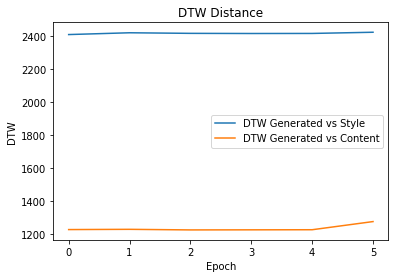

Start of iteration 56
Total loss: 5.794880390167236
Iteration 56 completed in 0s


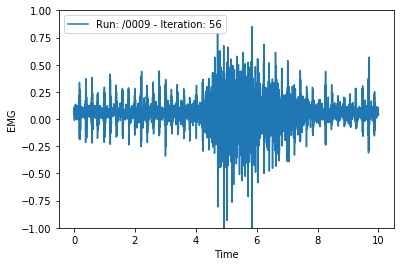

Metrics - Content CC:[169.22419743], FFT:152.15672775444716, DTW:1279.4987105377445
Metrics - Style CC:[-47.86814124], FFT:115.85645380988926, DTW:2422.943044867655


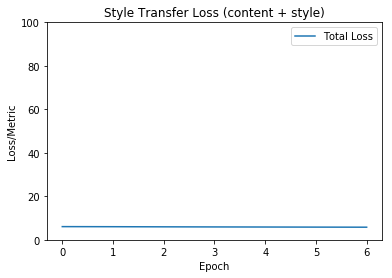

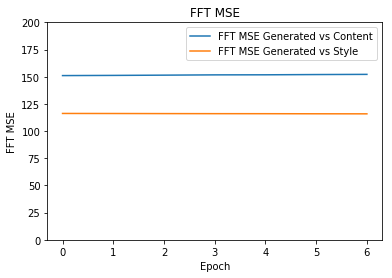

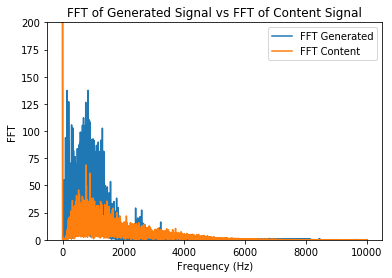

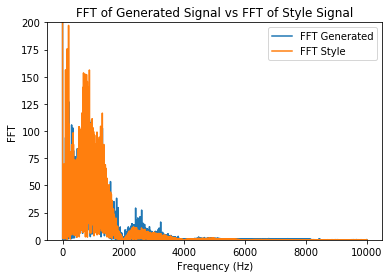

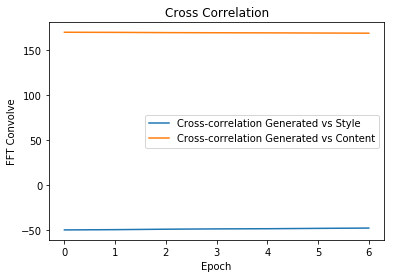

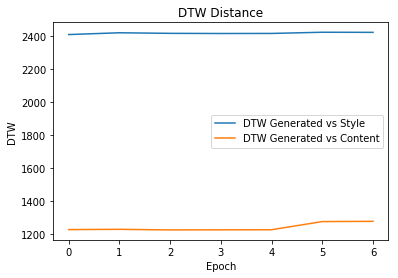

Start of iteration 57
Total loss: 5.758563995361328
Iteration 57 completed in 0s


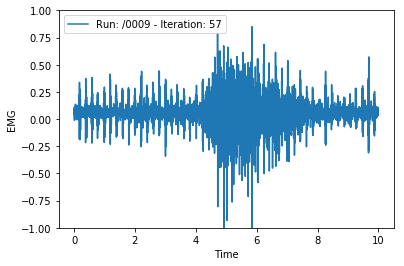

Metrics - Content CC:[169.1413982], FFT:152.28378556428856, DTW:1279.2403241363927
Metrics - Style CC:[-47.67261651], FFT:115.81521562164542, DTW:2421.2179662630415


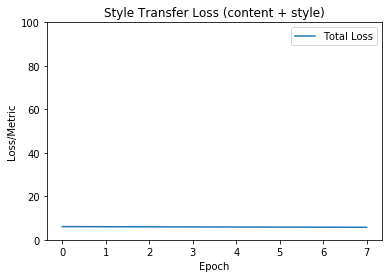

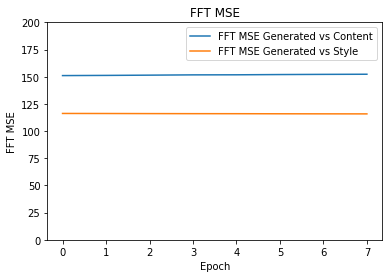

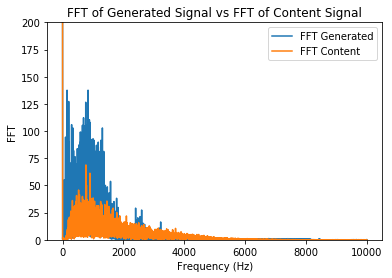

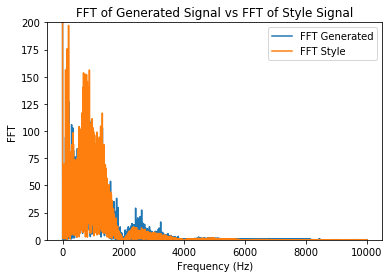

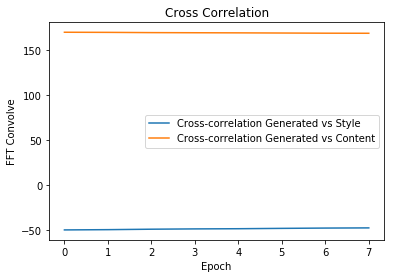

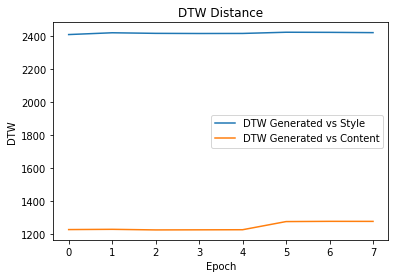

Start of iteration 58
Total loss: 5.699436187744141
Iteration 58 completed in 0s


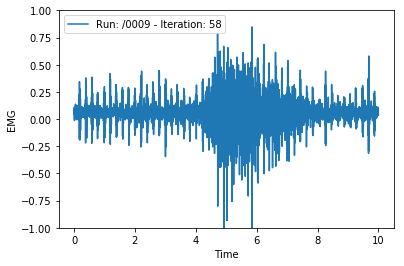

Metrics - Content CC:[168.71224119], FFT:152.67447912944655, DTW:1235.5048232562997
Metrics - Style CC:[-46.88501391], FFT:115.6694285131696, DTW:2404.808229343622


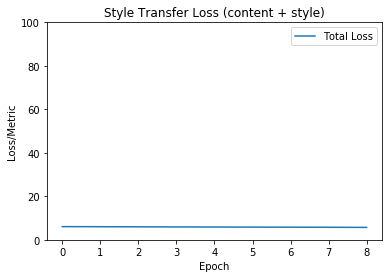

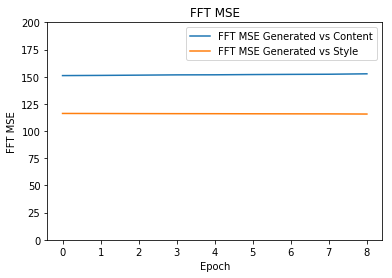

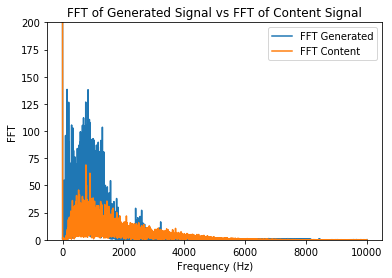

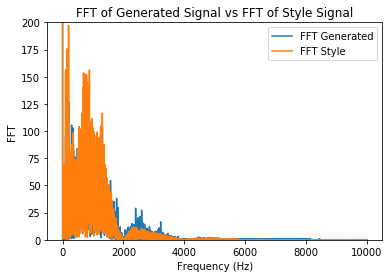

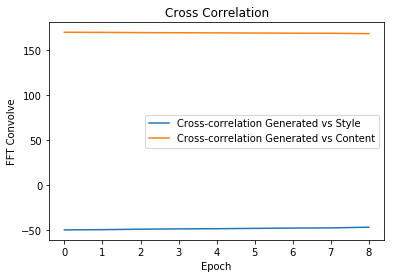

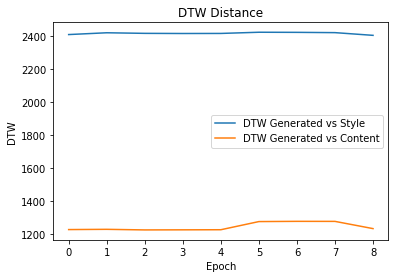

Start of iteration 59
Total loss: 5.646666526794434
Iteration 59 completed in 0s


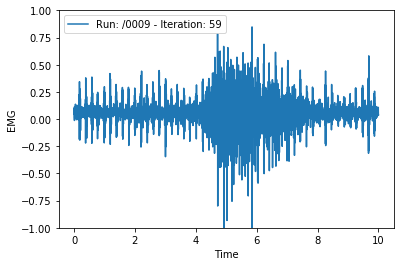

Metrics - Content CC:[168.6777307], FFT:152.76063994460398, DTW:1283.600988062777
Metrics - Style CC:[-46.76624103], FFT:115.64182742822943, DTW:2405.948553759608


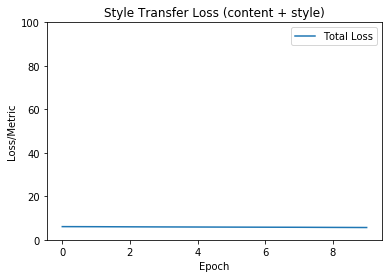

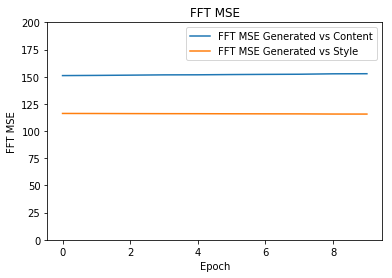

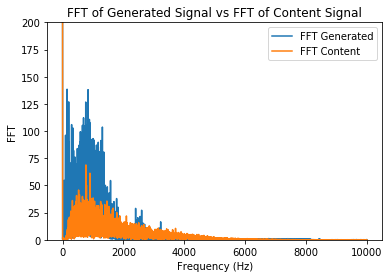

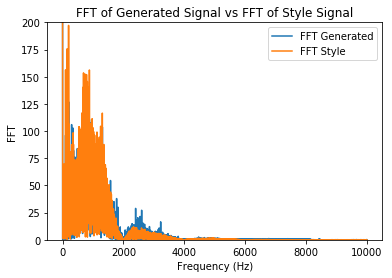

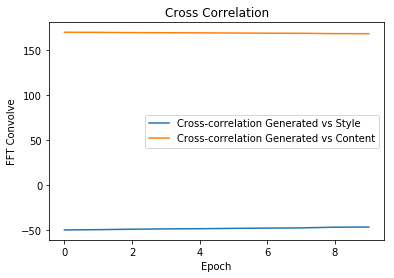

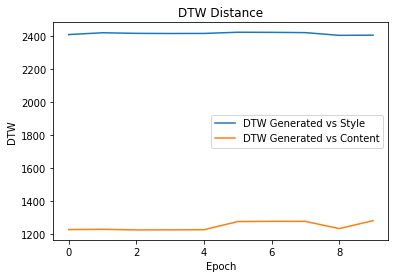

Start of iteration 60
Total loss: 5.591419219970703
Iteration 60 completed in 0s


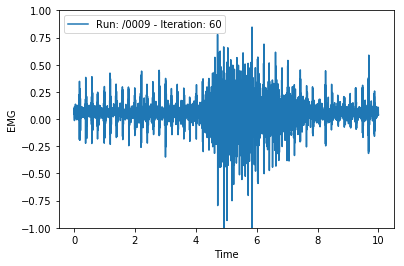

Metrics - Content CC:[168.34197888], FFT:153.08925994698637, DTW:1237.1683691812134
Metrics - Style CC:[-46.13604786], FFT:115.52603933371253, DTW:2404.6683267597036


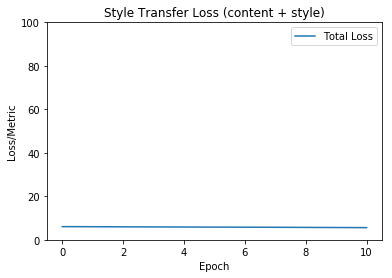

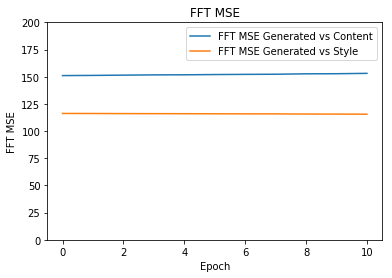

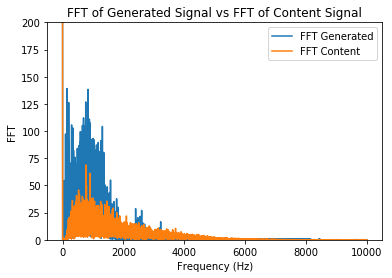

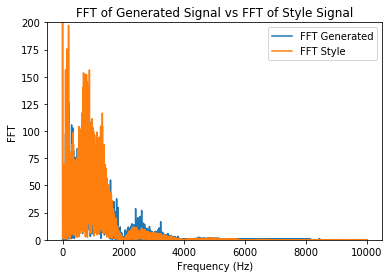

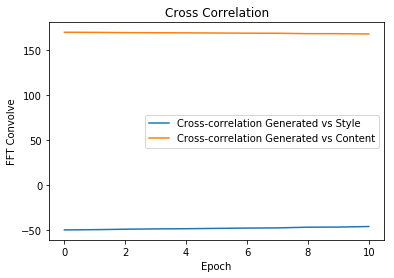

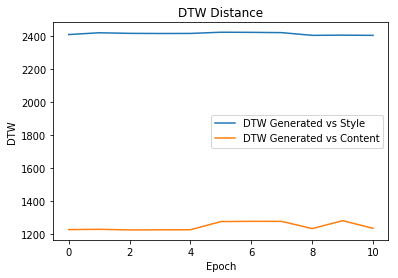

Start of iteration 61
Total loss: 5.552748680114746
Iteration 61 completed in 0s


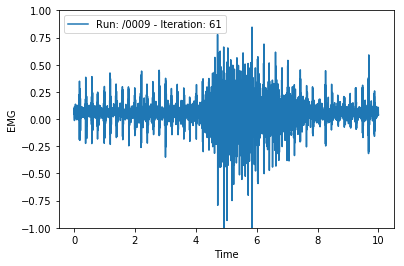

Metrics - Content CC:[168.26505401], FFT:153.20815347347775, DTW:1237.506506703939
Metrics - Style CC:[-45.93795795], FFT:115.48354023474006, DTW:2406.3215409620843


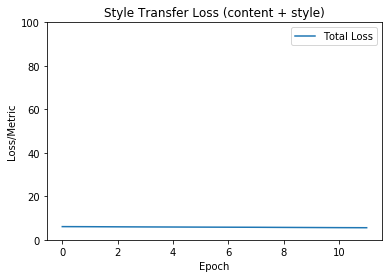

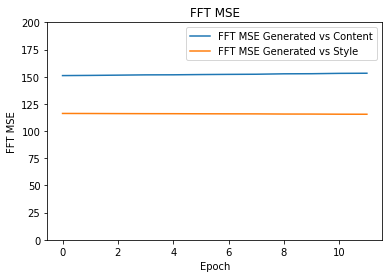

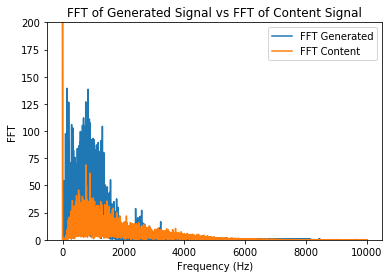

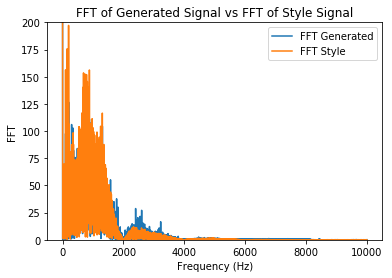

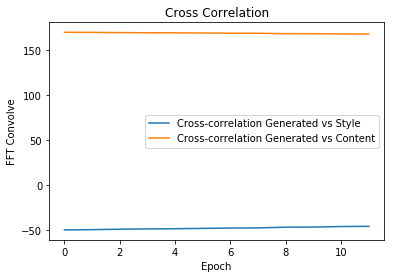

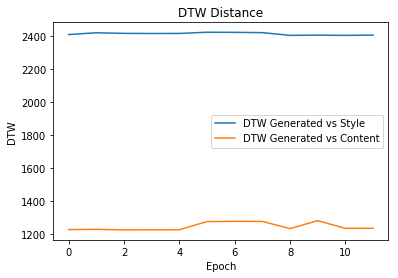

Start of iteration 62
Total loss: 5.526500225067139
Iteration 62 completed in 0s


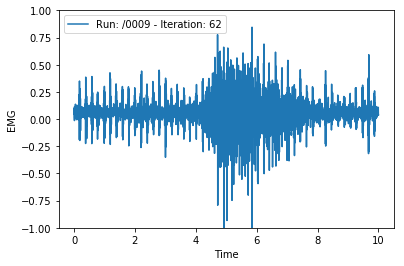

Metrics - Content CC:[168.1514403], FFT:153.30100097103775, DTW:1237.2169464808126
Metrics - Style CC:[-45.74266744], FFT:115.44865060809117, DTW:2406.271950843624


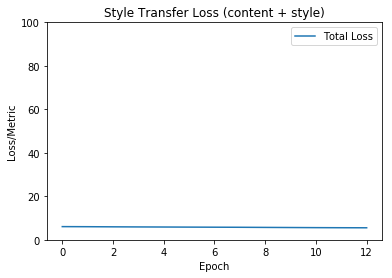

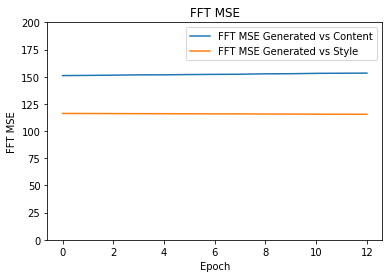

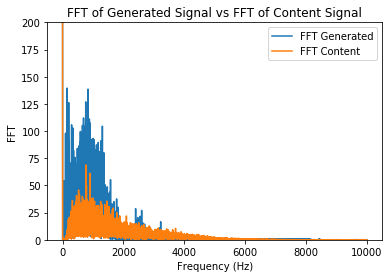

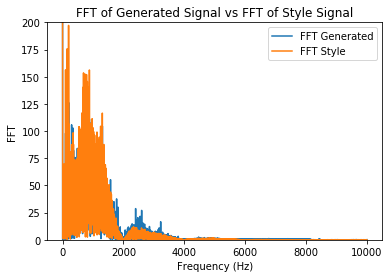

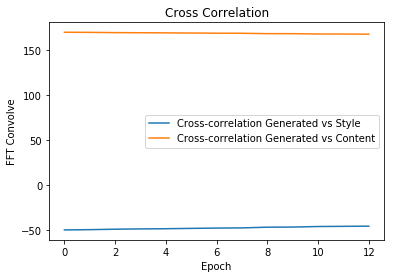

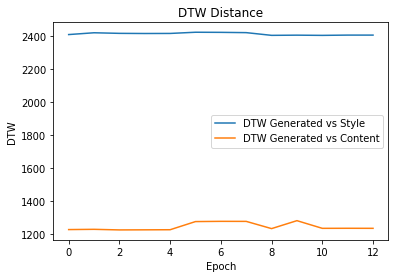

Start of iteration 63
Total loss: 5.48387336730957
Iteration 63 completed in 0s


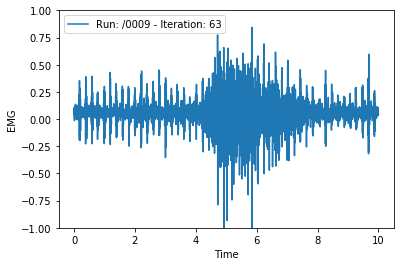

Metrics - Content CC:[167.91996652], FFT:153.5734651312624, DTW:1233.578717220515
Metrics - Style CC:[-45.25345235], FFT:115.3519072701022, DTW:2405.3513053242095


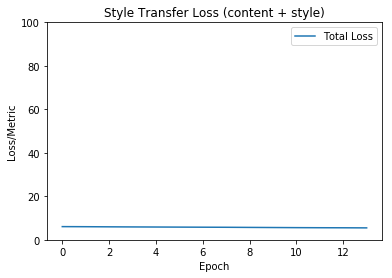

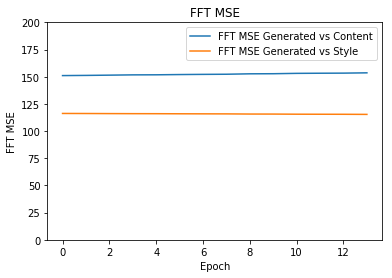

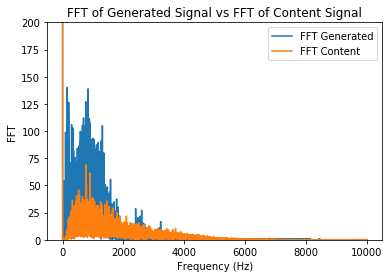

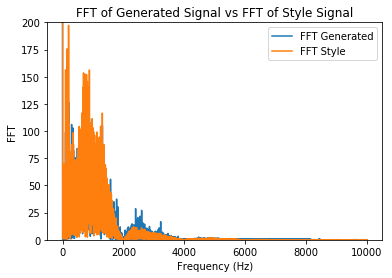

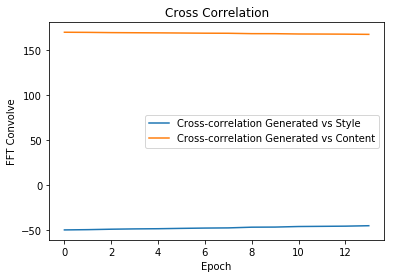

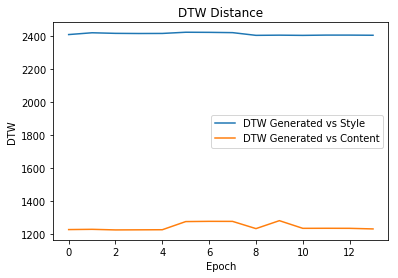

Start of iteration 64
Total loss: 5.446584224700928
Iteration 64 completed in 0s


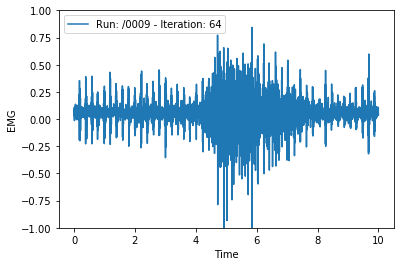

Metrics - Content CC:[167.80690018], FFT:153.67430508362708, DTW:1234.999492398645
Metrics - Style CC:[-45.0506411], FFT:115.3132811920884, DTW:2403.1673098170213


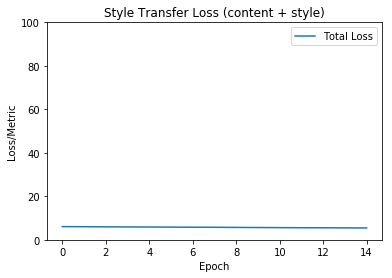

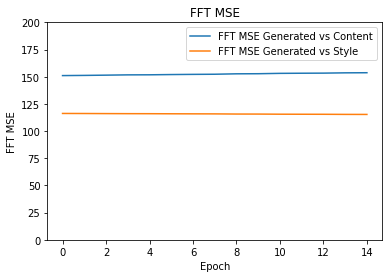

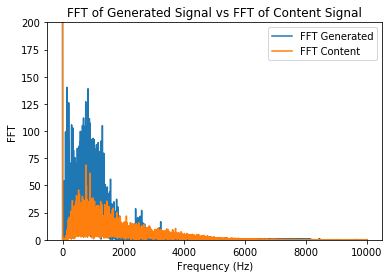

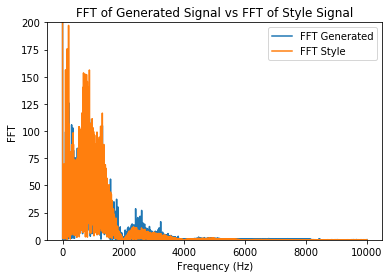

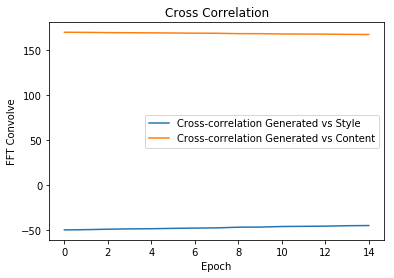

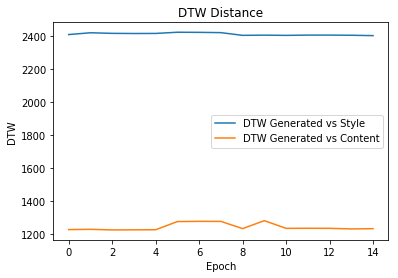

Start of iteration 65
Total loss: 5.417970180511475
Iteration 65 completed in 0s


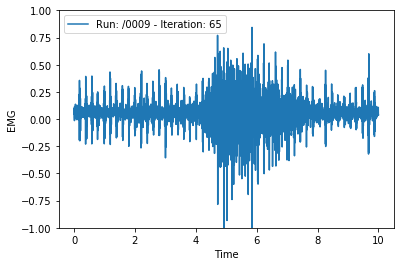

Metrics - Content CC:[167.65738336], FFT:153.82636527000946, DTW:1235.7092744802414
Metrics - Style CC:[-44.73823354], FFT:115.24594876356215, DTW:2401.7031252133957


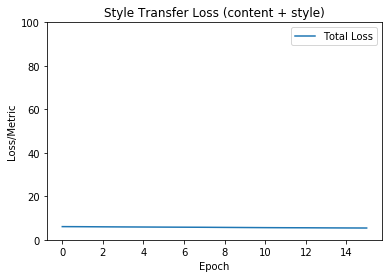

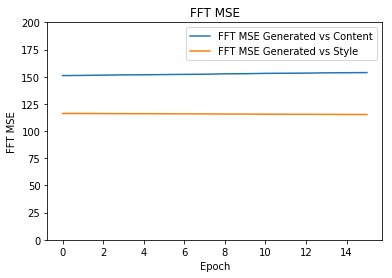

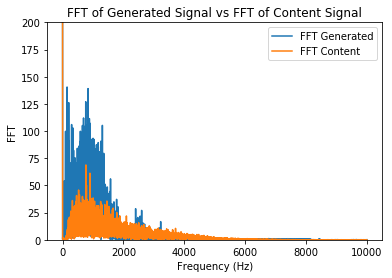

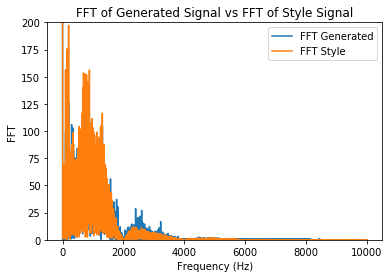

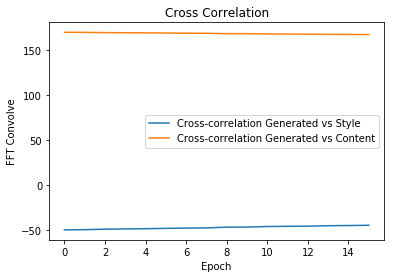

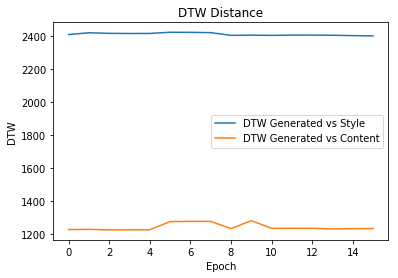

Start of iteration 66
Total loss: 5.385955810546875
Iteration 66 completed in 0s


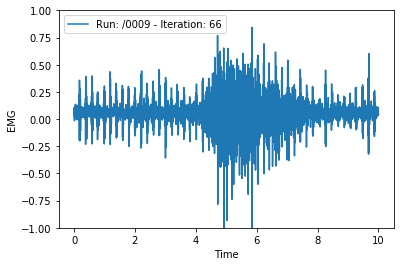

Metrics - Content CC:[167.53138459], FFT:153.96130378334152, DTW:1236.5284060295223
Metrics - Style CC:[-44.49544815], FFT:115.20069449582626, DTW:2399.9500857891717


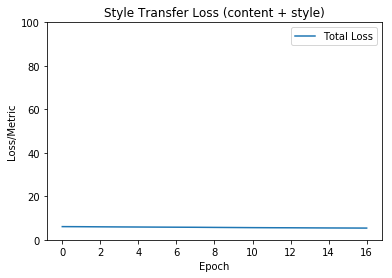

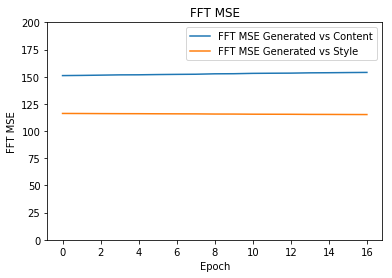

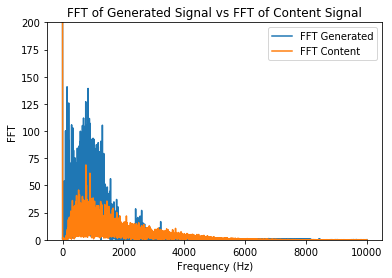

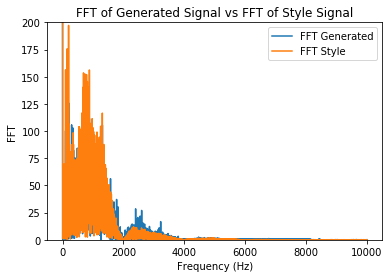

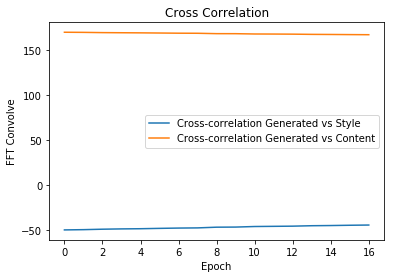

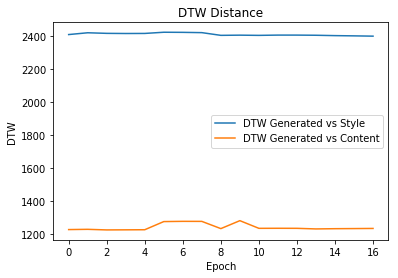

Start of iteration 67
Total loss: 5.3388214111328125
Iteration 67 completed in 0s


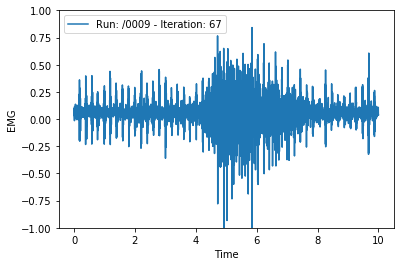

Metrics - Content CC:[167.28335952], FFT:154.23672688392674, DTW:1235.5368503007455
Metrics - Style CC:[-43.97592312], FFT:115.09084052574617, DTW:2402.577326949969


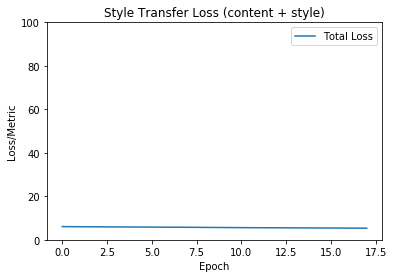

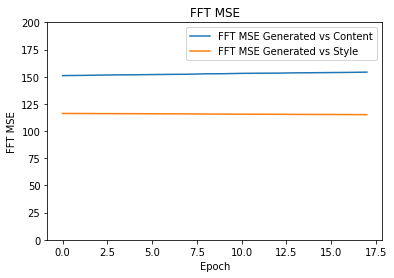

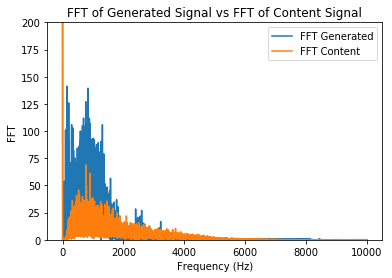

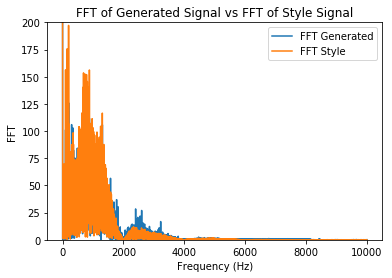

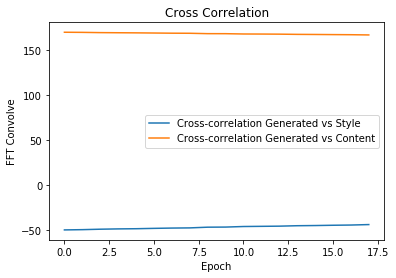

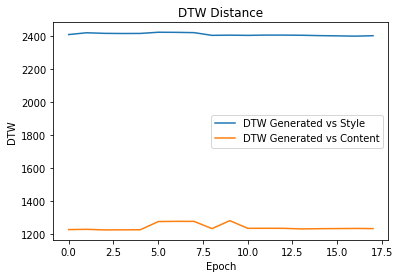

Start of iteration 68
Total loss: 5.297555923461914
Iteration 68 completed in 0s


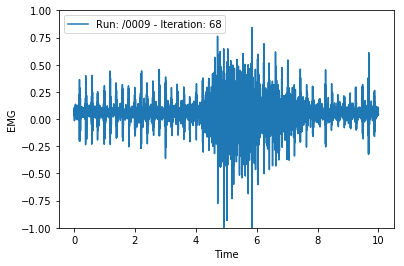

Metrics - Content CC:[167.07402232], FFT:154.42901134998553, DTW:1239.267481364038
Metrics - Style CC:[-43.57483029], FFT:114.99324729785637, DTW:2395.1144503429996


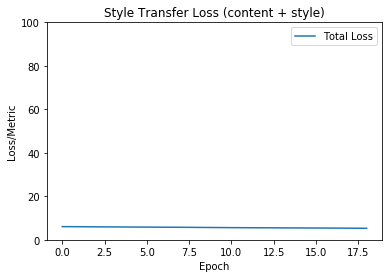

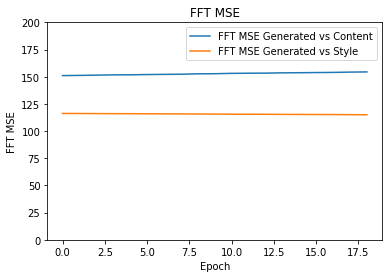

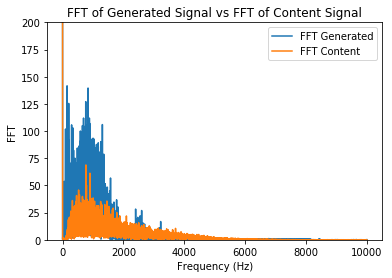

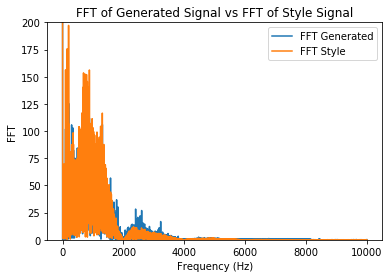

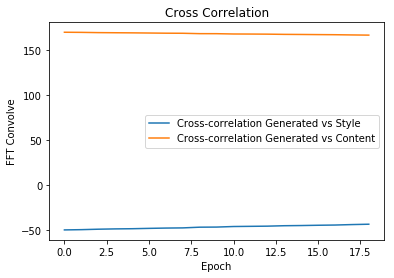

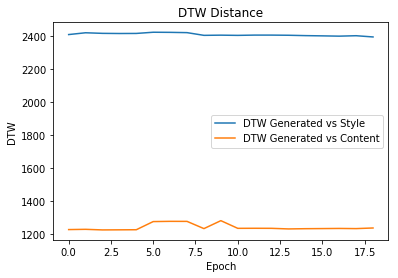

Start of iteration 69
Total loss: 5.262881278991699
Iteration 69 completed in 0s


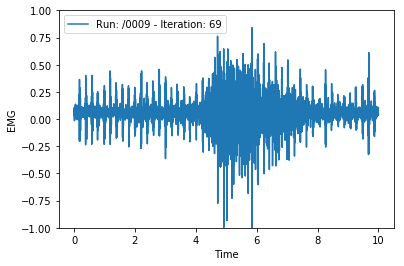

Metrics - Content CC:[166.97512999], FFT:154.55126909206632, DTW:1241.060200674354
Metrics - Style CC:[-43.35641268], FFT:114.9525346766288, DTW:2397.3304735444867


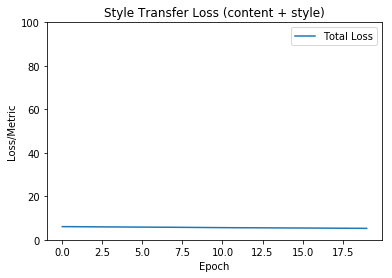

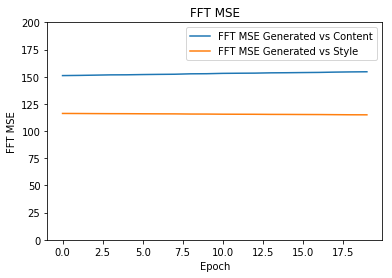

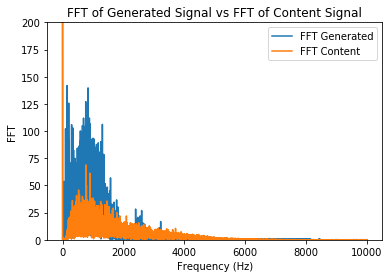

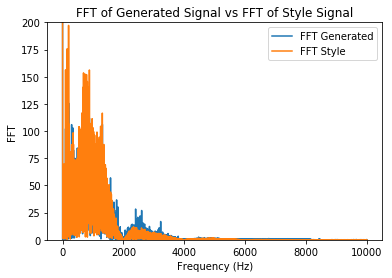

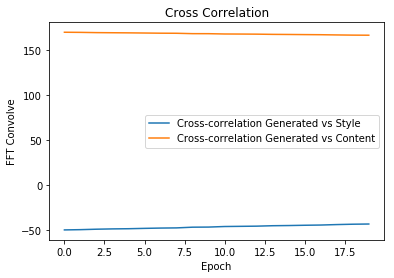

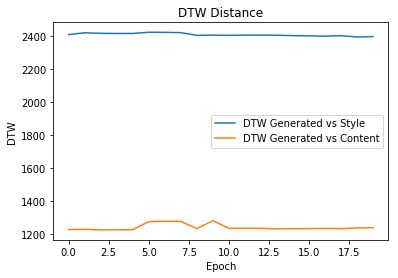

Start of iteration 70
Total loss: 5.231992721557617
Iteration 70 completed in 0s


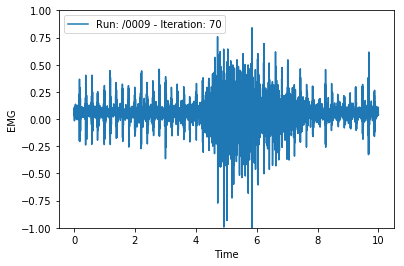

Metrics - Content CC:[166.76988593], FFT:154.7447685447085, DTW:1240.7239852123423
Metrics - Style CC:[-42.95911952], FFT:114.8648444265203, DTW:2395.206206909195


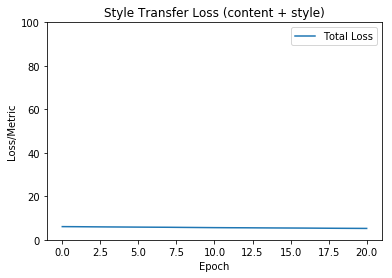

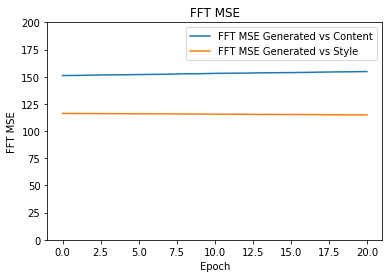

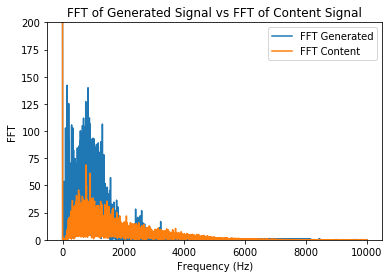

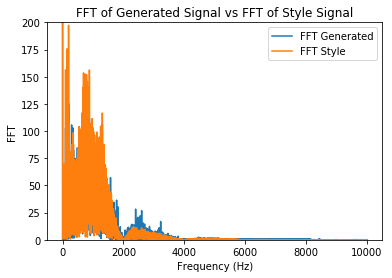

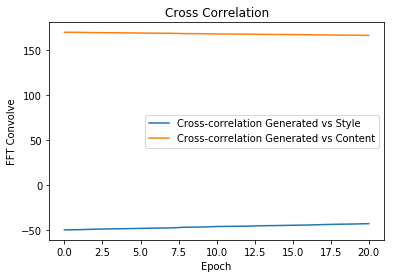

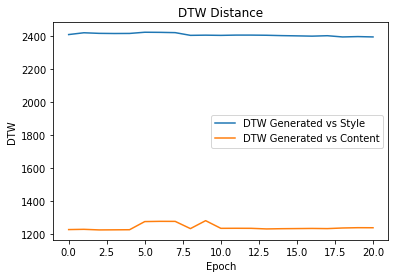

Start of iteration 71
Total loss: 5.200683116912842
Iteration 71 completed in 0s


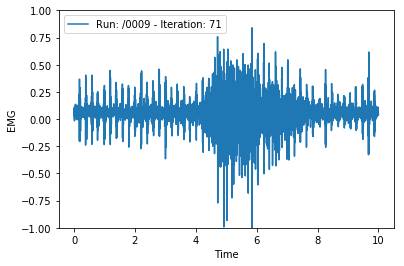

Metrics - Content CC:[166.70152175], FFT:154.82778601311003, DTW:1241.569468888659
Metrics - Style CC:[-42.80577101], FFT:114.83520410334025, DTW:2404.777985935532


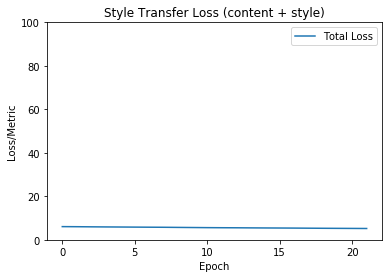

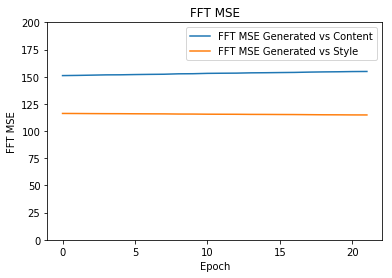

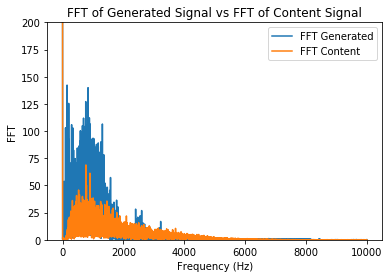

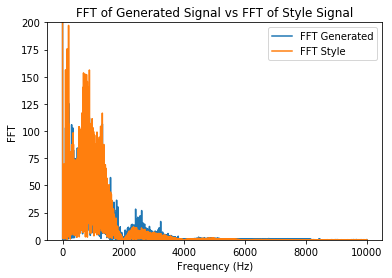

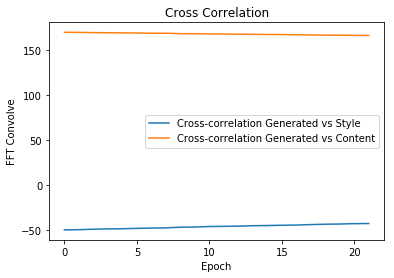

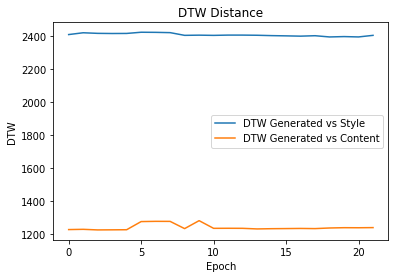

Start of iteration 72
Total loss: 5.135681629180908
Iteration 72 completed in 0s


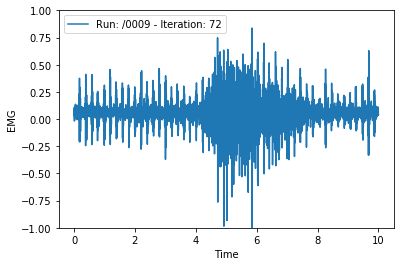

Metrics - Content CC:[166.04466304], FFT:155.49848376250998, DTW:1244.7897588215403
Metrics - Style CC:[-41.50003369], FFT:114.55592790256664, DTW:2403.2472647991112


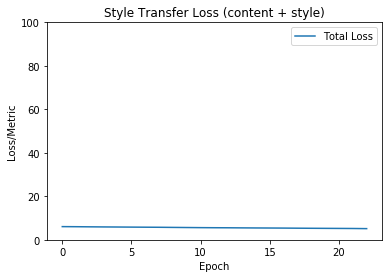

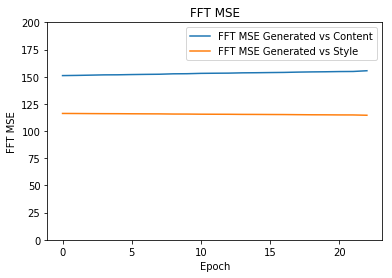

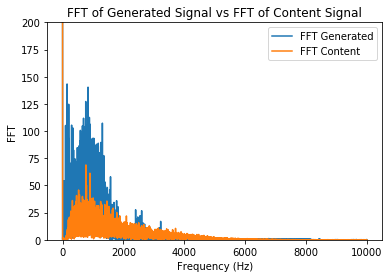

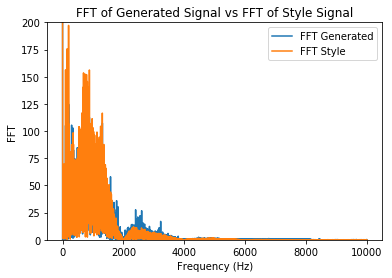

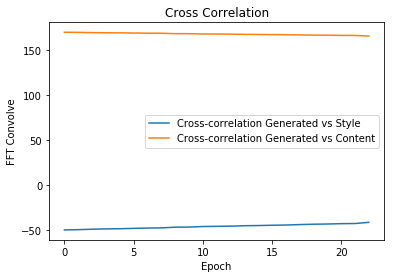

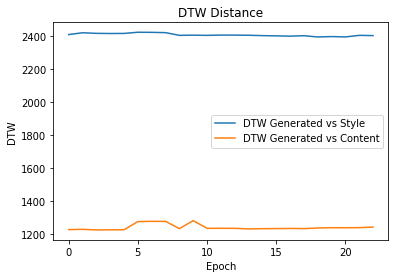

Start of iteration 73
Total loss: 5.065590858459473
Iteration 73 completed in 0s


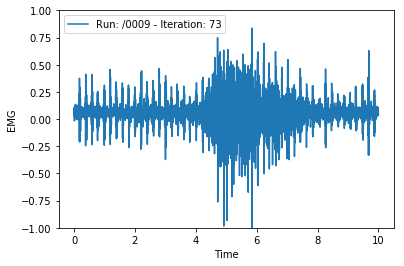

Metrics - Content CC:[166.02631975], FFT:155.52895008729573, DTW:1238.7684551442094
Metrics - Style CC:[-41.43232835], FFT:114.52934094991365, DTW:2401.1920253217713


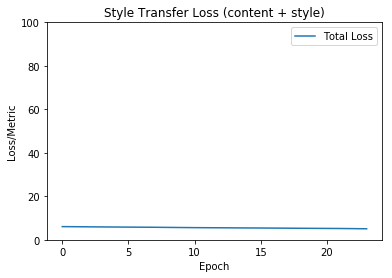

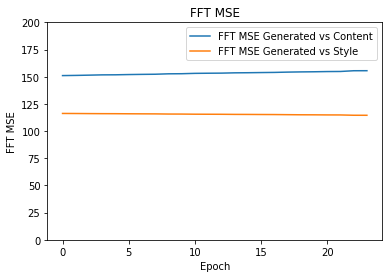

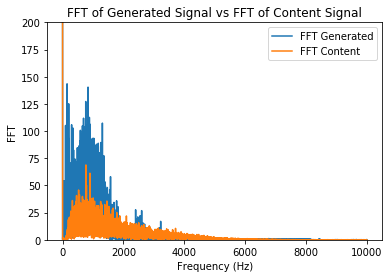

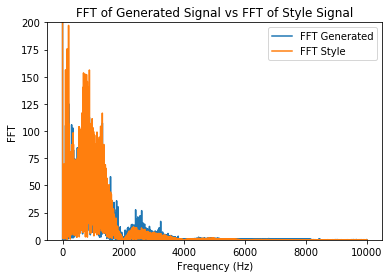

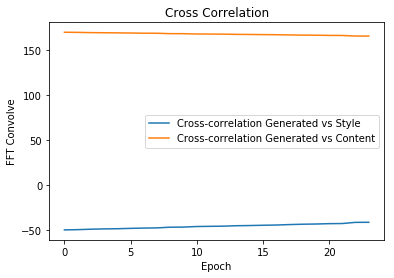

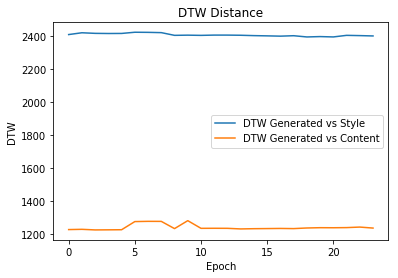

Start of iteration 74
Total loss: 4.99874210357666
Iteration 74 completed in 0s


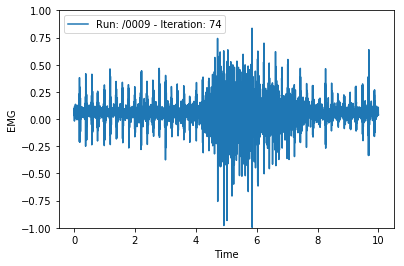

Metrics - Content CC:[165.55061458], FFT:155.9803935375692, DTW:1220.6394313936157
Metrics - Style CC:[-40.49439527], FFT:114.3366517124805, DTW:2385.4573868050547


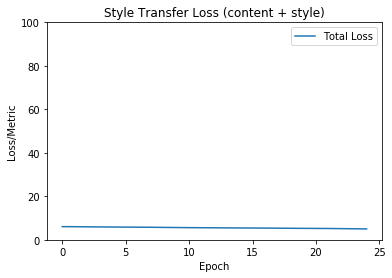

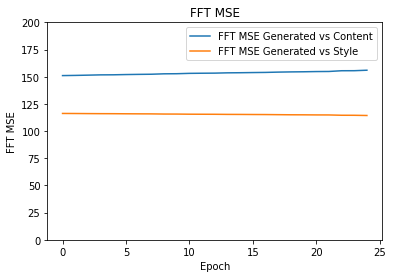

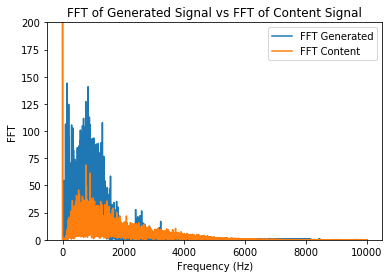

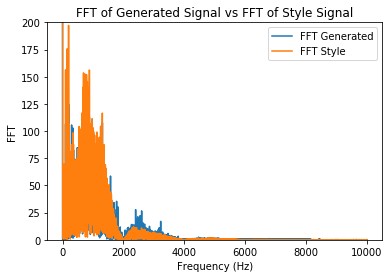

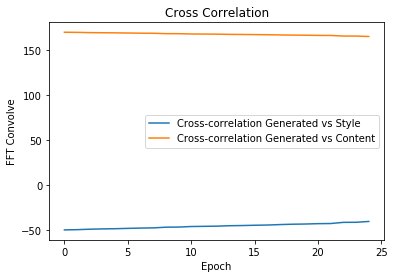

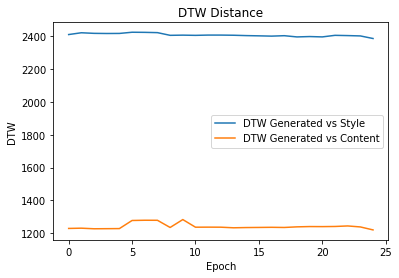

Start of iteration 75
Total loss: 4.969764232635498
Iteration 75 completed in 0s


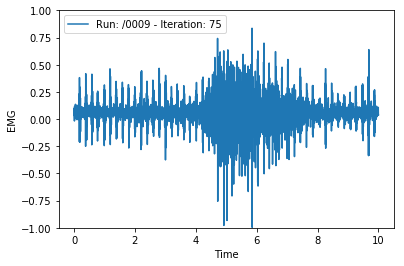

Metrics - Content CC:[165.54215207], FFT:156.02343509973358, DTW:1216.8862846540253
Metrics - Style CC:[-40.42665029], FFT:114.30518709391954, DTW:2387.091420439363


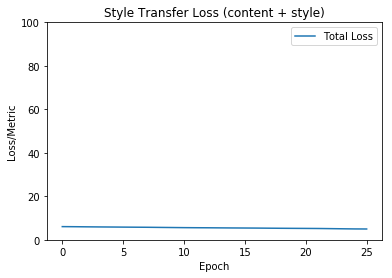

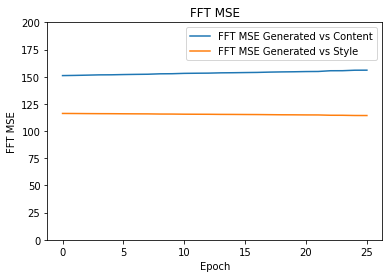

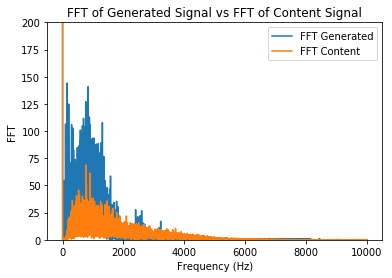

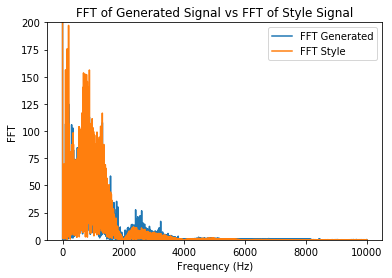

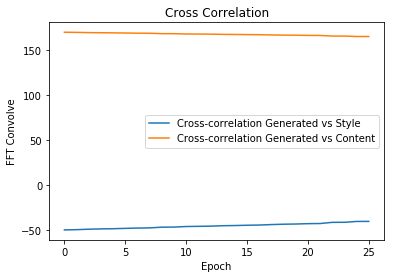

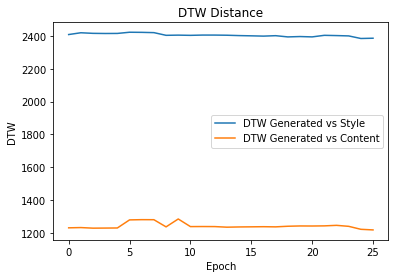

Start of iteration 76
Total loss: 4.938858985900879
Iteration 76 completed in 0s


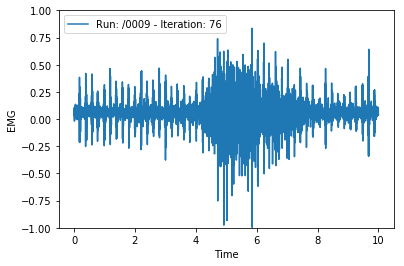

Metrics - Content CC:[165.28779377], FFT:156.24969959155212, DTW:1240.75598080792
Metrics - Style CC:[-39.91889717], FFT:114.19851951967782, DTW:2386.564092761254


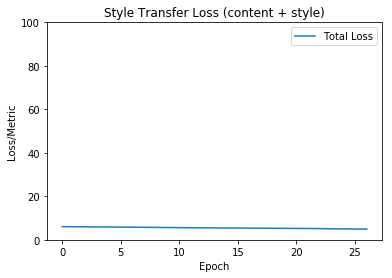

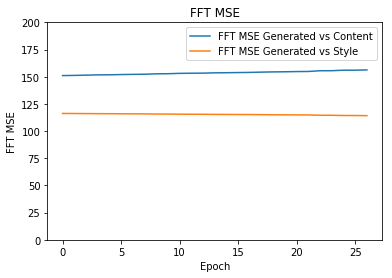

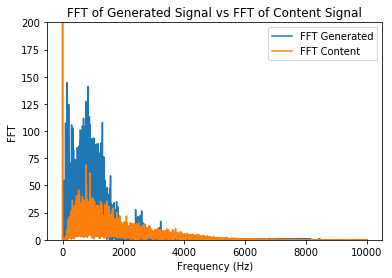

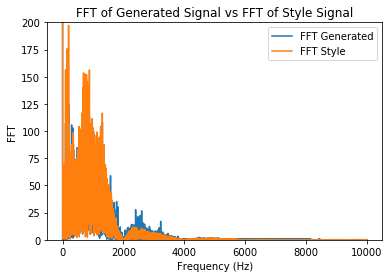

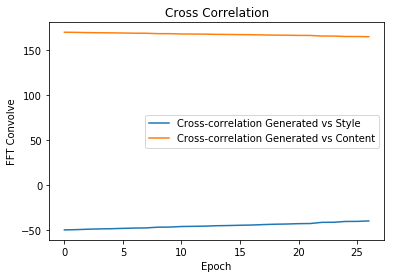

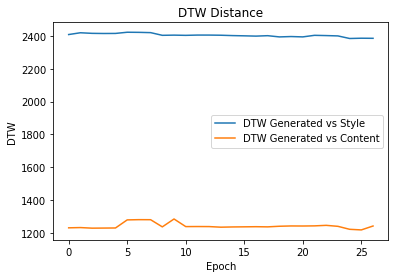

Start of iteration 77
Total loss: 4.912595748901367
Iteration 77 completed in 0s


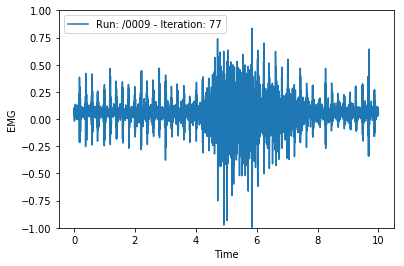

Metrics - Content CC:[165.25692518], FFT:156.31544327003334, DTW:1215.945863021859
Metrics - Style CC:[-39.81421424], FFT:114.16770855994517, DTW:2384.716458129693


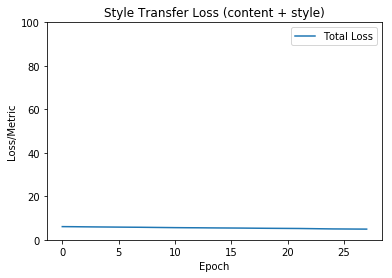

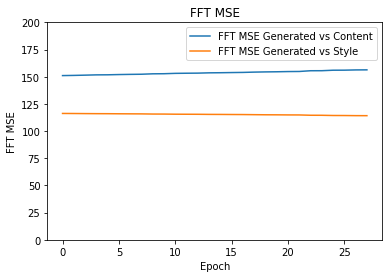

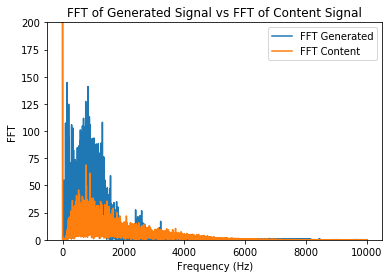

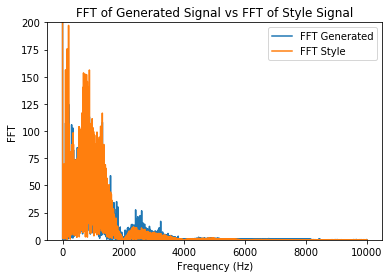

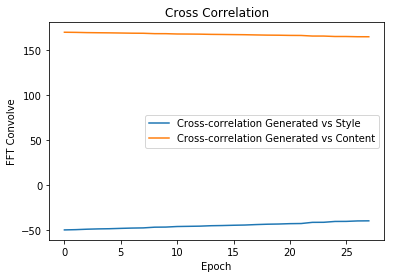

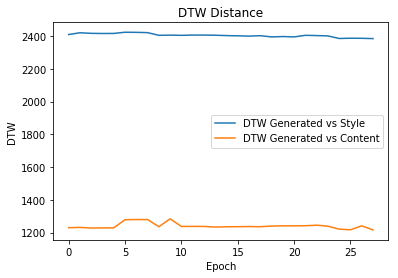

Start of iteration 78
Total loss: 4.855101108551025
Iteration 78 completed in 0s


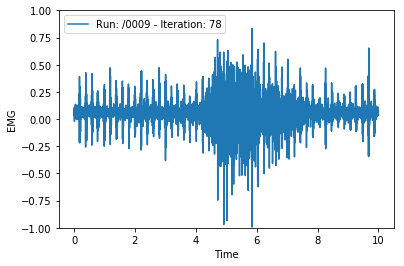

Metrics - Content CC:[164.70615061], FFT:156.8341850021511, DTW:1244.2372098002168
Metrics - Style CC:[-38.68945408], FFT:113.92142449927353, DTW:2399.6320178810256


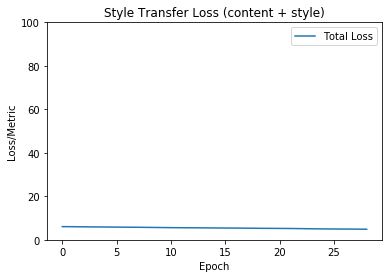

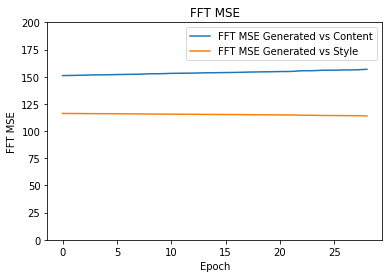

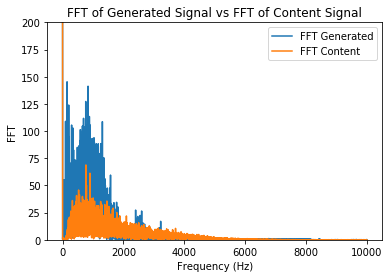

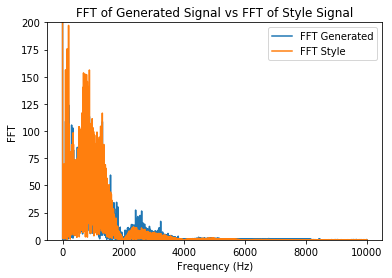

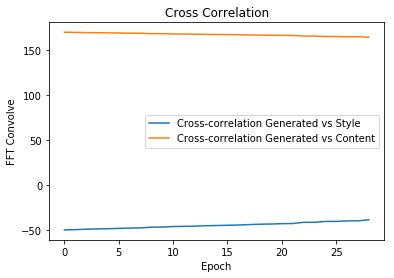

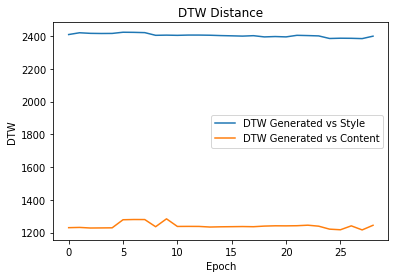

Start of iteration 79
Total loss: 4.803509712219238
Iteration 79 completed in 0s


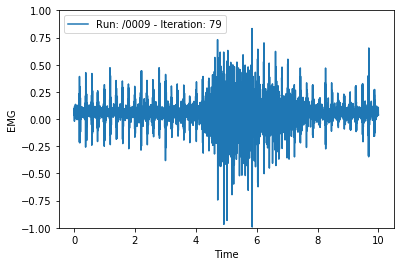

Metrics - Content CC:[164.69635226], FFT:156.88830103410783, DTW:1208.9844189524345
Metrics - Style CC:[-38.61539391], FFT:113.89598734124964, DTW:2407.268883029322


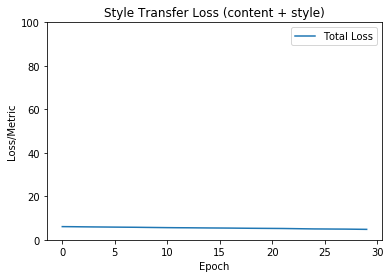

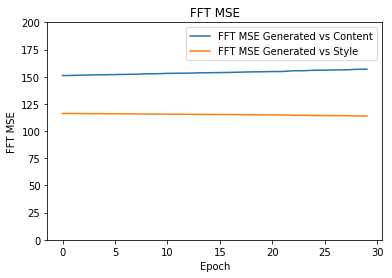

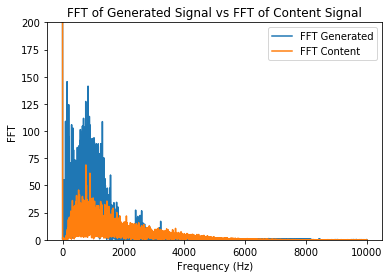

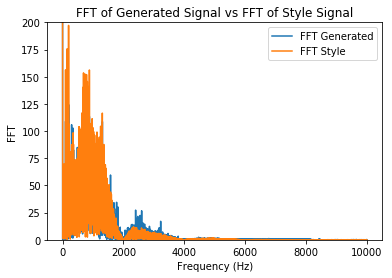

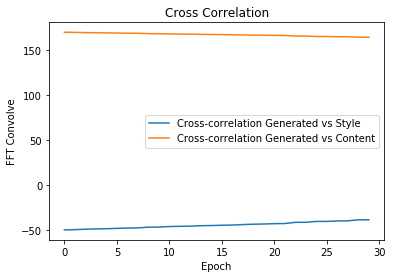

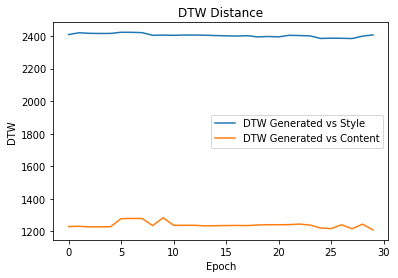

Start of iteration 80
Total loss: 4.724845886230469
Iteration 80 completed in 0s


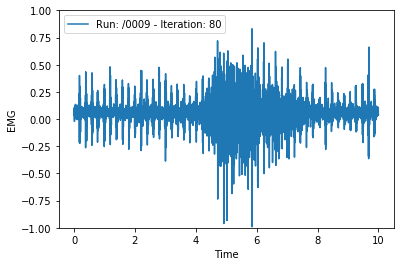

Metrics - Content CC:[164.01567719], FFT:157.60874327581965, DTW:1216.8066869706283
Metrics - Style CC:[-37.12074003], FFT:113.54282730981069, DTW:2412.1055796404353


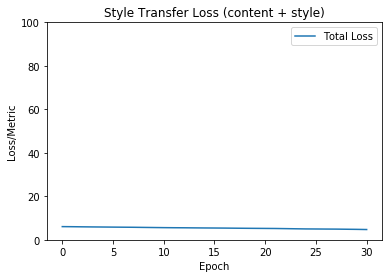

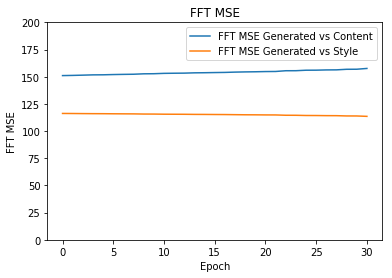

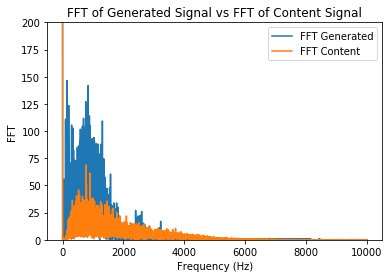

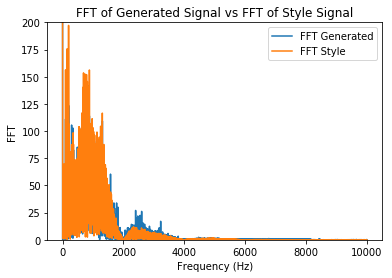

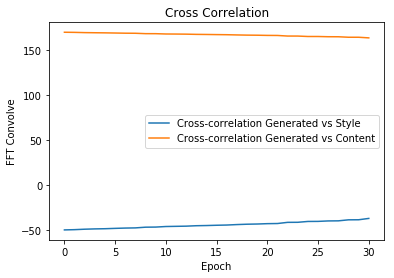

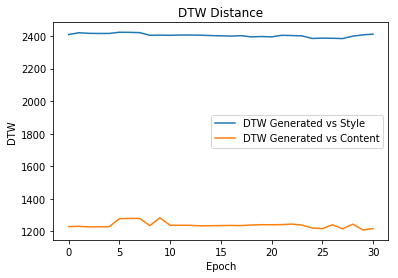

Start of iteration 81
Total loss: 4.669078826904297
Iteration 81 completed in 0s


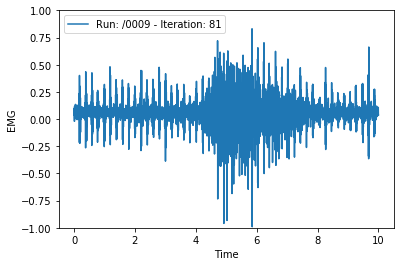

Metrics - Content CC:[163.99500303], FFT:157.63634876368647, DTW:1216.7562797997546
Metrics - Style CC:[-37.05102008], FFT:113.5184613338841, DTW:2410.9082526796196


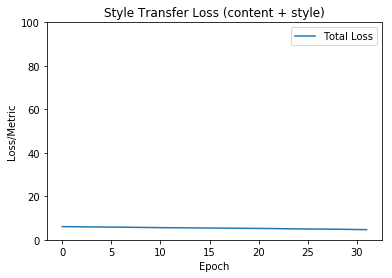

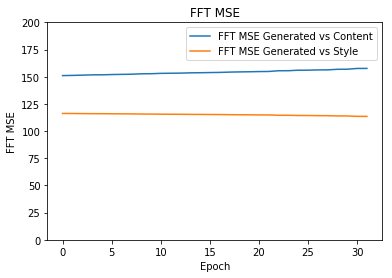

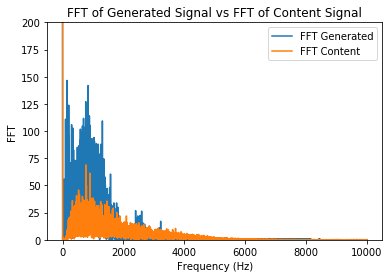

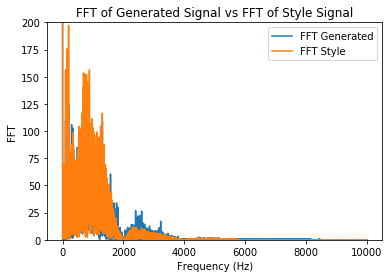

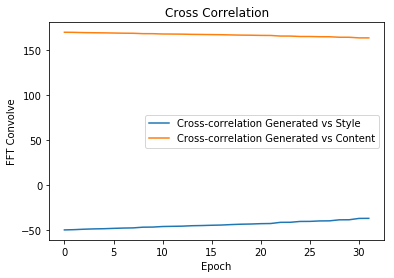

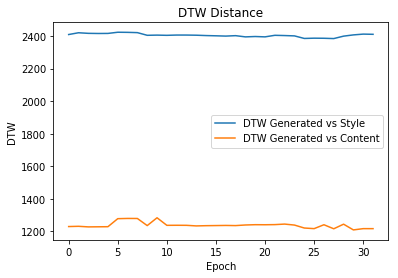

Start of iteration 82
Total loss: 4.584011077880859
Iteration 82 completed in 0s


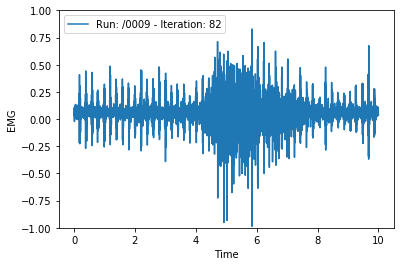

Metrics - Content CC:[163.31372717], FFT:158.26295569155945, DTW:1217.3581220972296
Metrics - Style CC:[-35.67740846], FFT:113.2399841411028, DTW:2409.163436745478


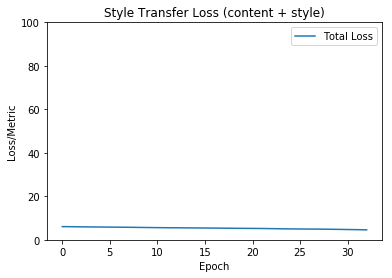

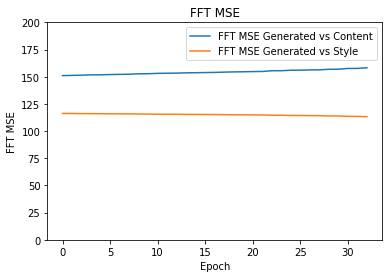

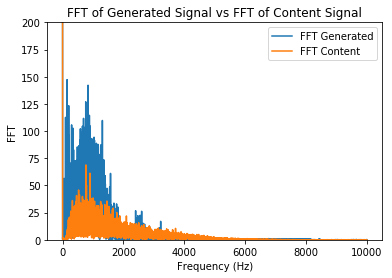

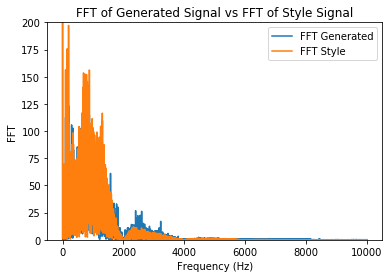

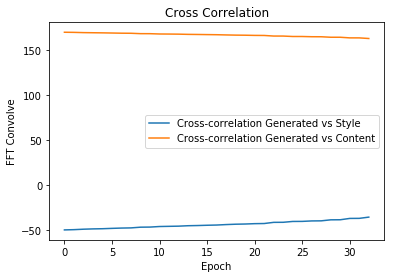

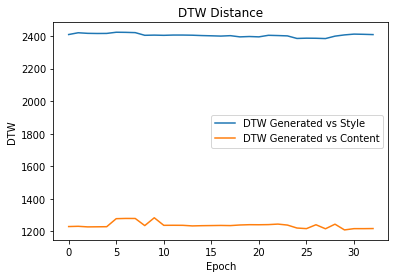

Start of iteration 83
Total loss: 4.546429634094238
Iteration 83 completed in 0s


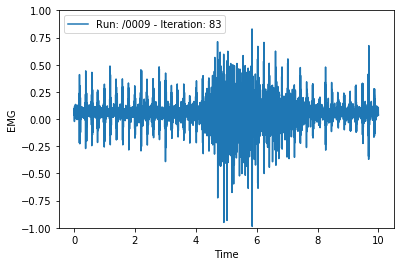

Metrics - Content CC:[163.303896], FFT:158.33226444542626, DTW:1216.636722446319
Metrics - Style CC:[-35.59039191], FFT:113.20824787127786, DTW:2410.159938347981


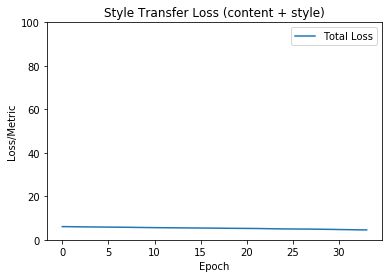

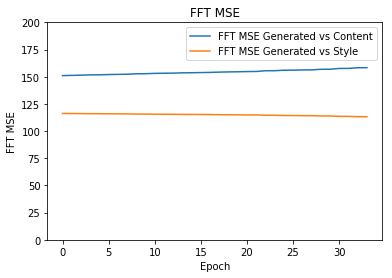

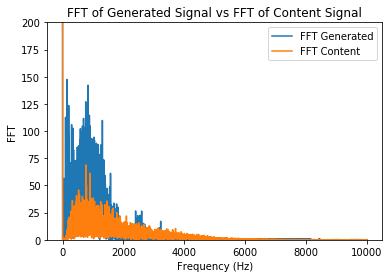

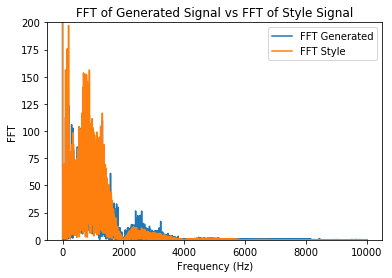

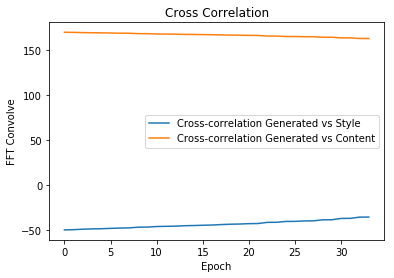

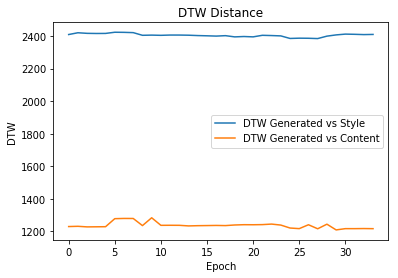

Start of iteration 84
Total loss: 4.517626762390137
Iteration 84 completed in 0s


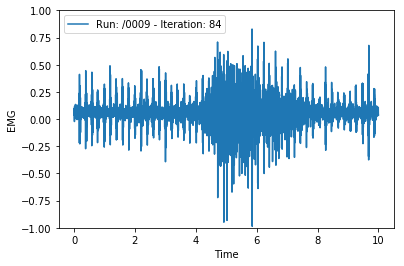

Metrics - Content CC:[163.07066924], FFT:158.52464410692042, DTW:1222.3822654538017
Metrics - Style CC:[-35.12461008], FFT:113.12207660950756, DTW:2406.043842765234


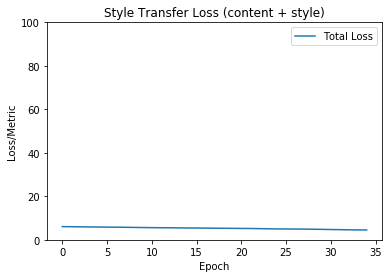

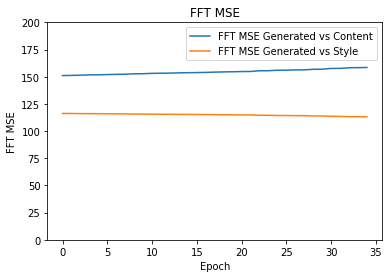

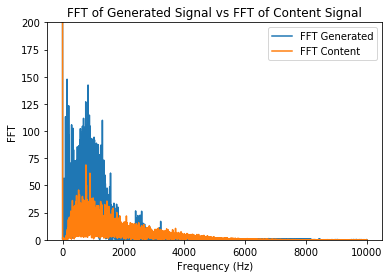

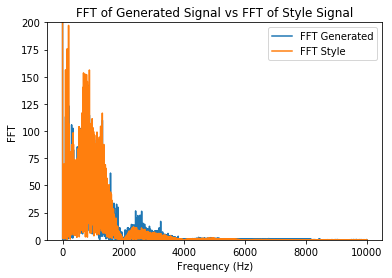

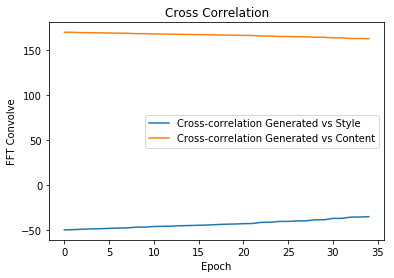

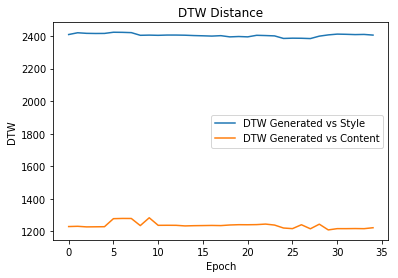

Start of iteration 85
Total loss: 4.494297504425049
Iteration 85 completed in 0s


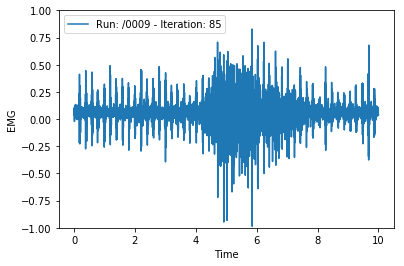

Metrics - Content CC:[163.01232974], FFT:158.64294950073833, DTW:1223.2430483370786
Metrics - Style CC:[-34.92190543], FFT:113.05973651977061, DTW:2413.450334459559


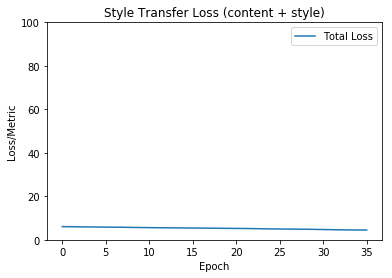

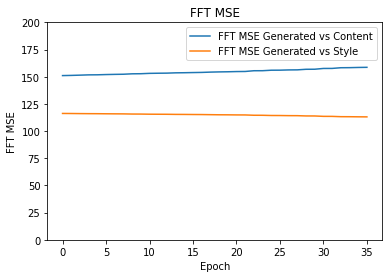

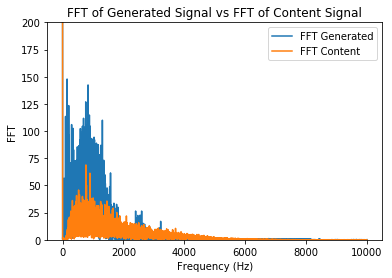

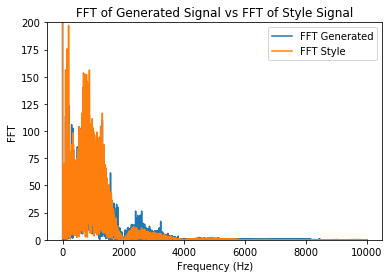

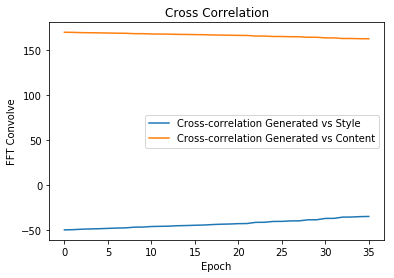

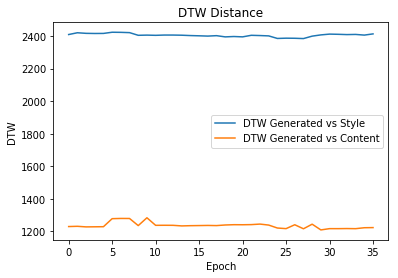

Start of iteration 86
Total loss: 4.477447986602783
Iteration 86 completed in 0s


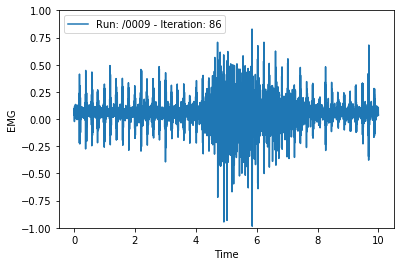

Metrics - Content CC:[162.90821322], FFT:158.7118217789048, DTW:1222.9820047337653
Metrics - Style CC:[-34.74289615], FFT:113.03138024568514, DTW:2415.1880164280656


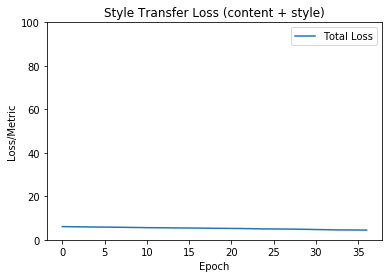

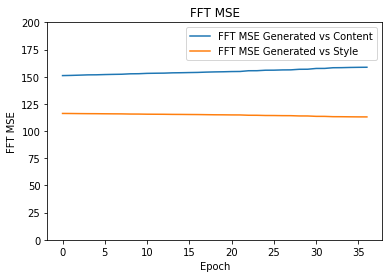

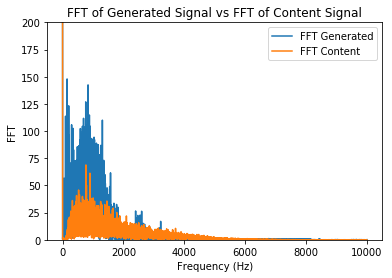

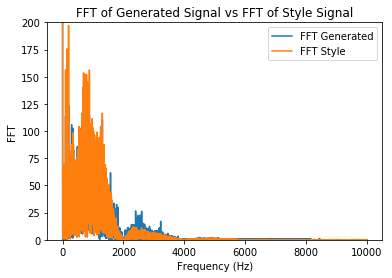

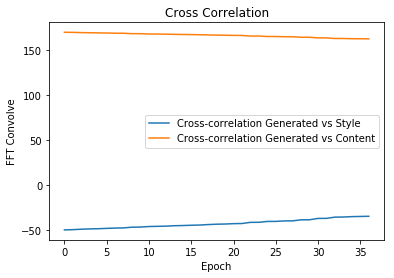

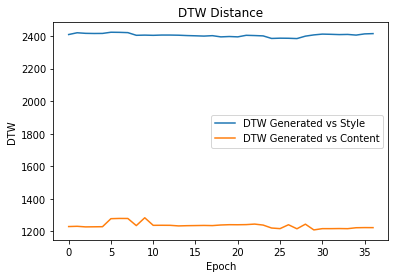

Start of iteration 87
Total loss: 4.457599639892578
Iteration 87 completed in 0s


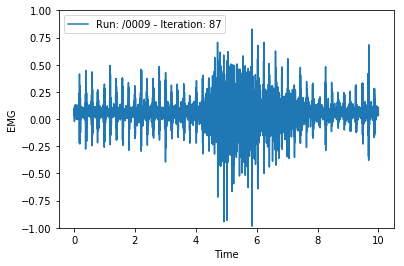

Metrics - Content CC:[162.80626501], FFT:158.83511972731725, DTW:1222.4579741531336
Metrics - Style CC:[-34.48383871], FFT:112.96278567350524, DTW:2416.005131229707


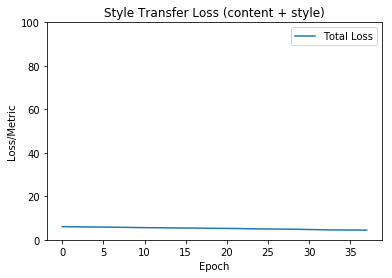

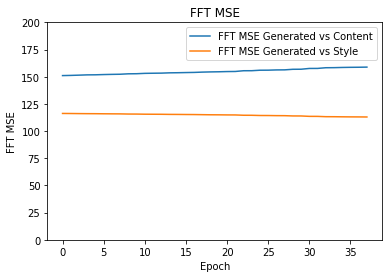

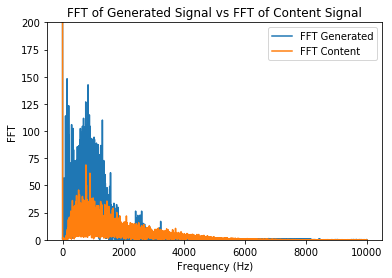

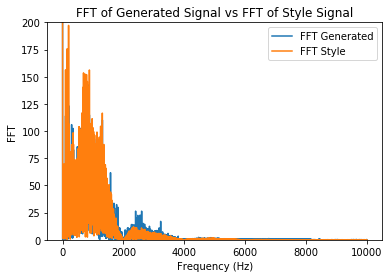

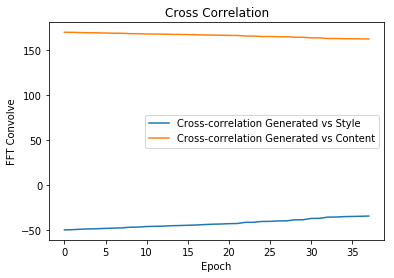

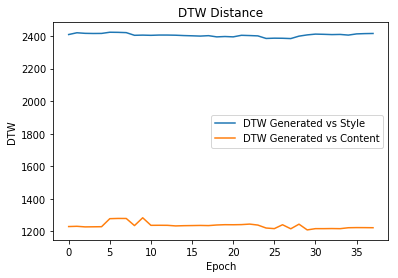

Start of iteration 88
Total loss: 4.43776798248291
Iteration 88 completed in 0s


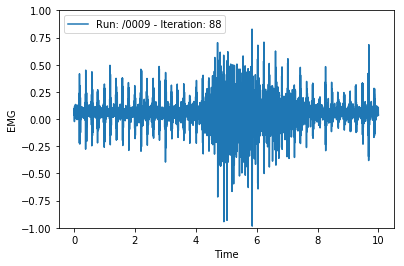

Metrics - Content CC:[162.66744342], FFT:158.9457135216431, DTW:1221.4126063703302
Metrics - Style CC:[-34.21300968], FFT:112.90944941990867, DTW:2408.4443928109185


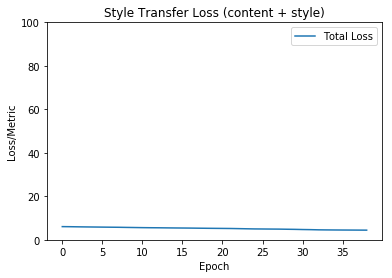

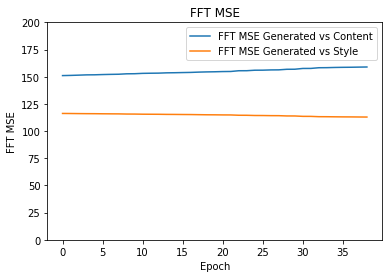

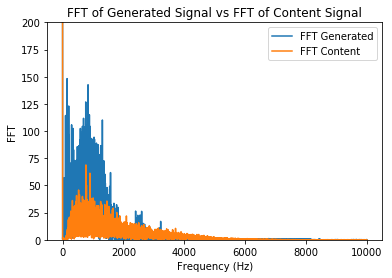

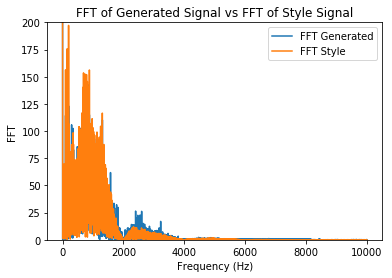

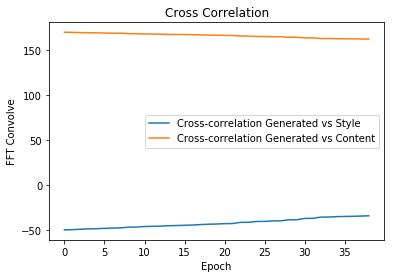

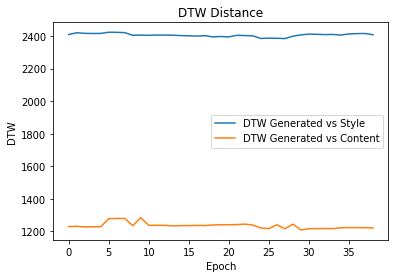

Start of iteration 89
Total loss: 4.417323112487793
Iteration 89 completed in 0s


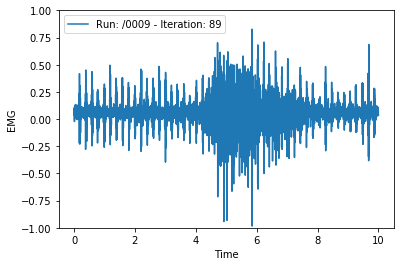

Metrics - Content CC:[162.55781977], FFT:159.0768805363515, DTW:1223.0946521434985
Metrics - Style CC:[-33.94235061], FFT:112.84303718756924, DTW:2406.0120378115826


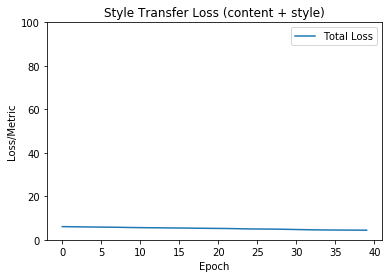

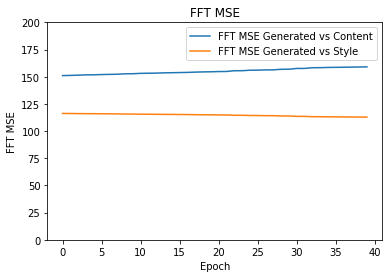

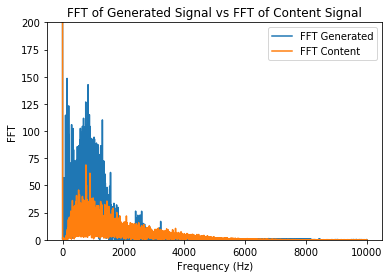

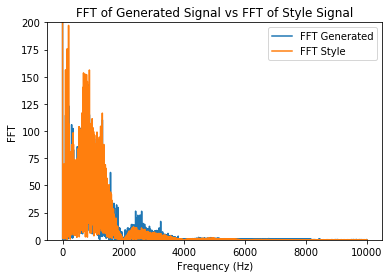

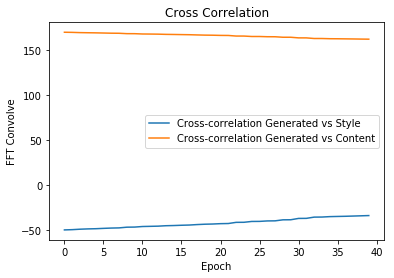

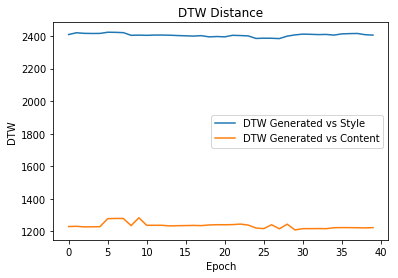

Start of iteration 90
Total loss: 4.40165901184082
Iteration 90 completed in 0s


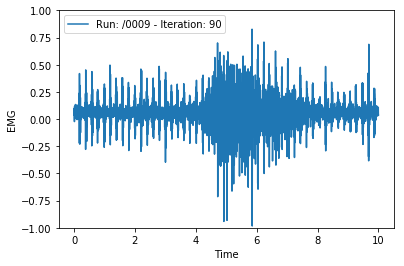

Metrics - Content CC:[162.46530889], FFT:159.15530929690485, DTW:1223.2827085663907
Metrics - Style CC:[-33.76685941], FFT:112.81085165811476, DTW:2392.615495675408


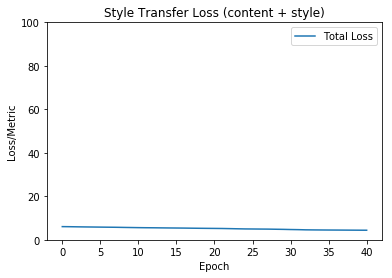

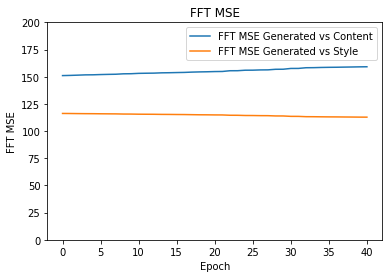

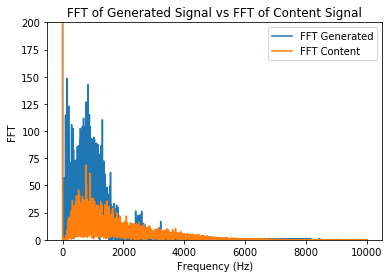

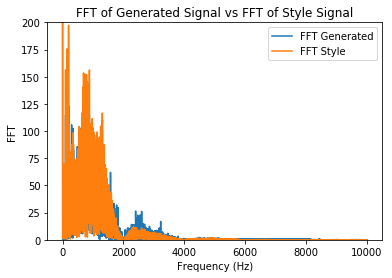

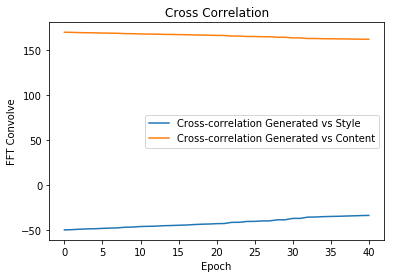

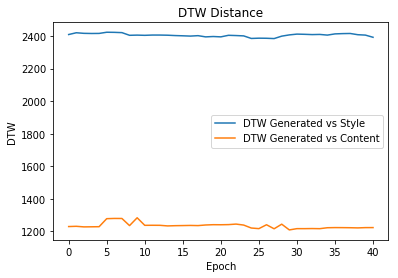

Start of iteration 91
Total loss: 4.38662052154541
Iteration 91 completed in 0s


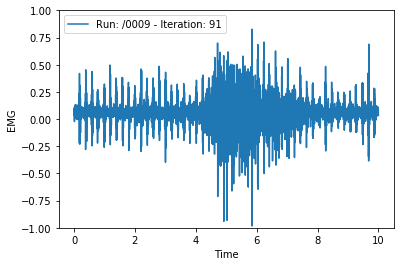

Metrics - Content CC:[162.39251011], FFT:159.209404700925, DTW:1219.663448910204
Metrics - Style CC:[-33.5976386], FFT:112.76359761701626, DTW:2383.160589701658


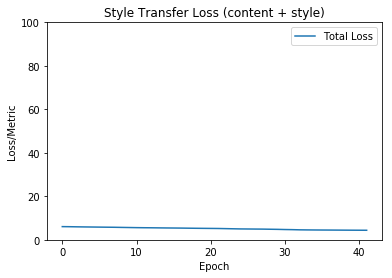

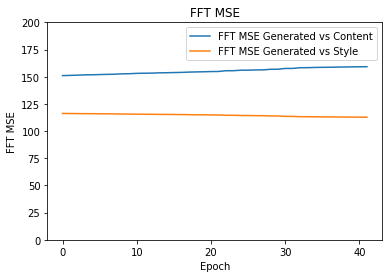

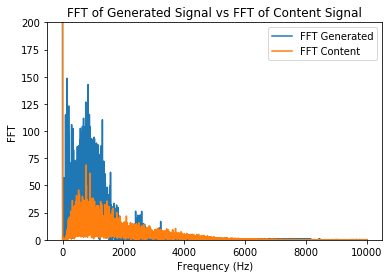

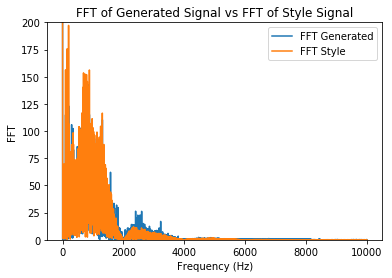

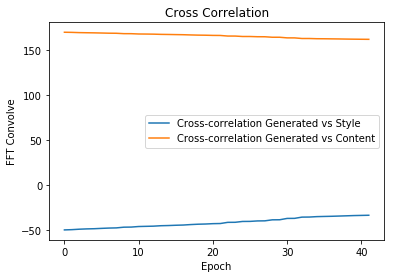

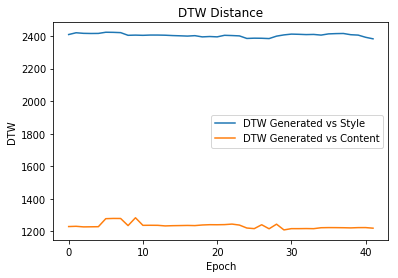

Start of iteration 92
Total loss: 4.364445209503174
Iteration 92 completed in 0s


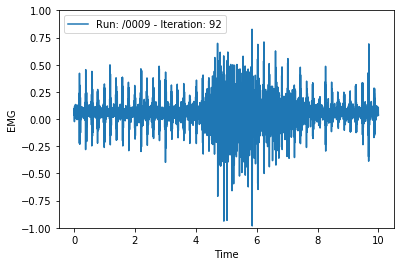

Metrics - Content CC:[162.23170477], FFT:159.38352061430103, DTW:1224.2632422084585
Metrics - Style CC:[-33.24385037], FFT:112.68590661635612, DTW:2378.184284972408


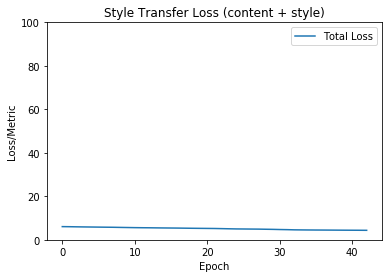

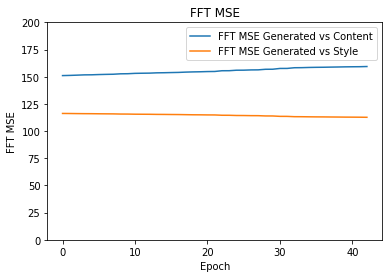

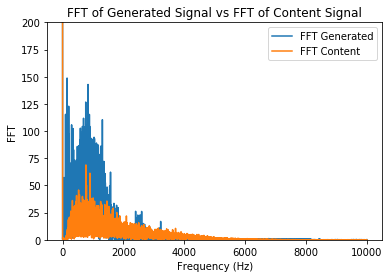

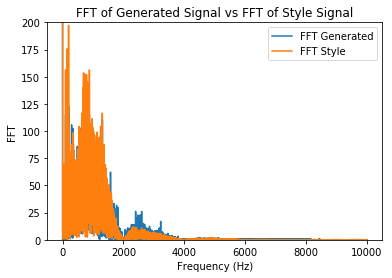

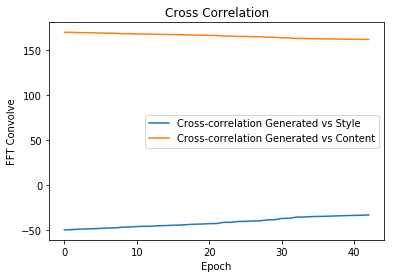

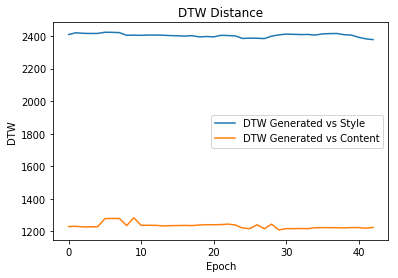

Start of iteration 93
Total loss: 4.348349571228027
Iteration 93 completed in 0s


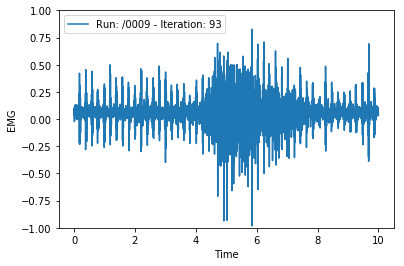

Metrics - Content CC:[162.17611167], FFT:159.44300197225925, DTW:1221.5874827555442
Metrics - Style CC:[-33.10589491], FFT:112.654342467186, DTW:2378.3641189085633


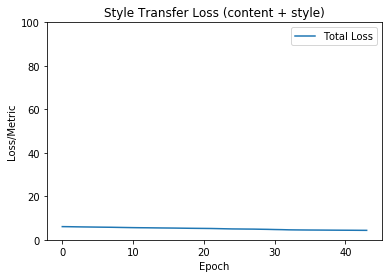

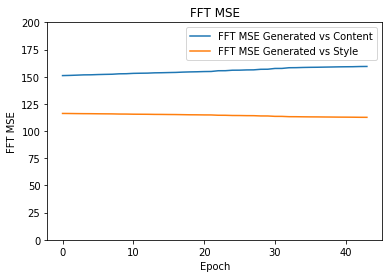

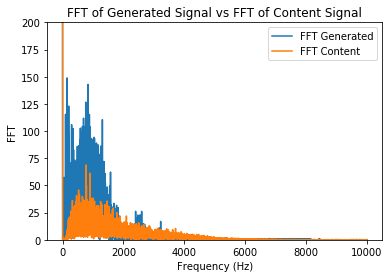

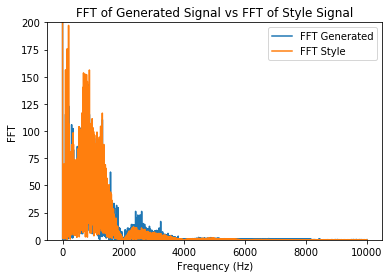

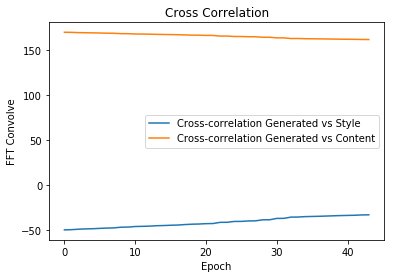

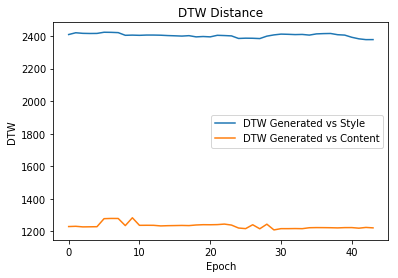

Start of iteration 94
Total loss: 4.330255508422852
Iteration 94 completed in 0s


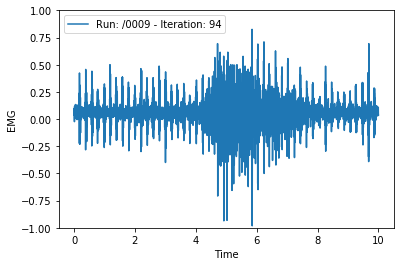

Metrics - Content CC:[162.02341084], FFT:159.57908460417985, DTW:1221.5448893582877
Metrics - Style CC:[-32.79360033], FFT:112.58802608071356, DTW:2377.228799803385


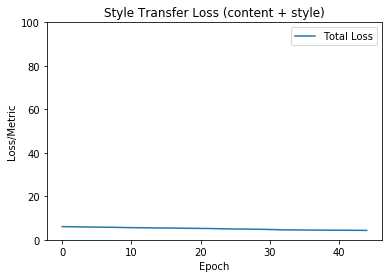

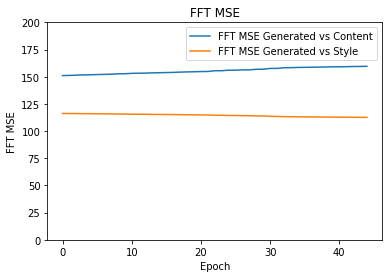

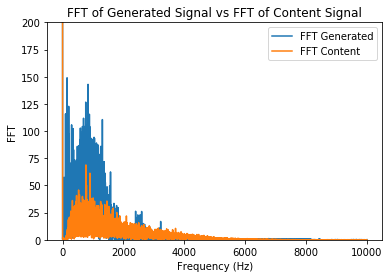

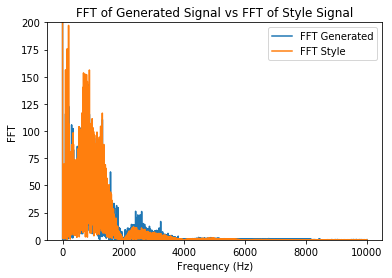

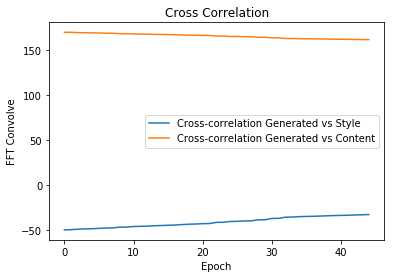

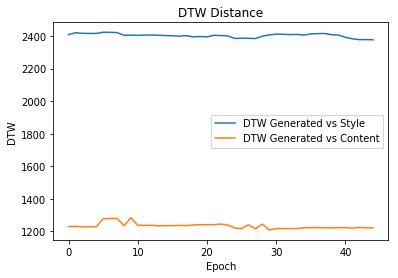

Start of iteration 95
Total loss: 4.312967300415039
Iteration 95 completed in 0s


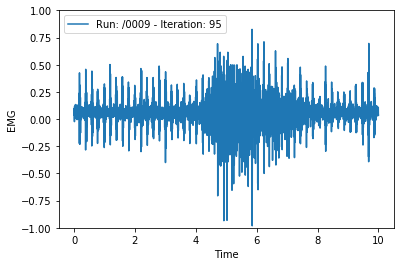

Metrics - Content CC:[161.93107109], FFT:159.67492962692037, DTW:1219.1362114984959
Metrics - Style CC:[-32.56773504], FFT:112.53525937608106, DTW:2377.203676317461


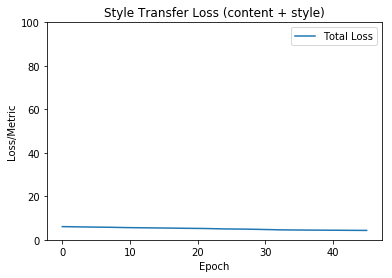

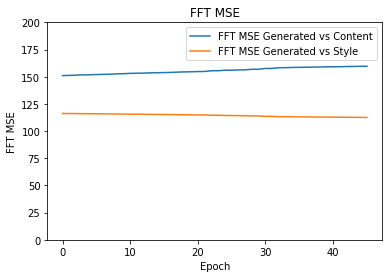

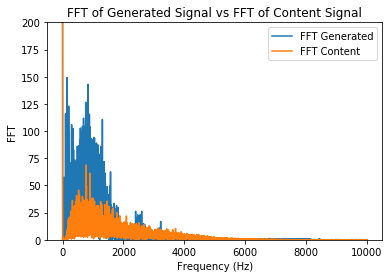

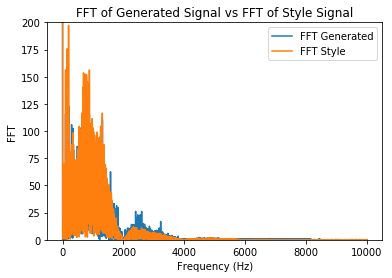

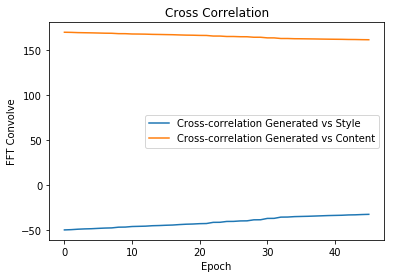

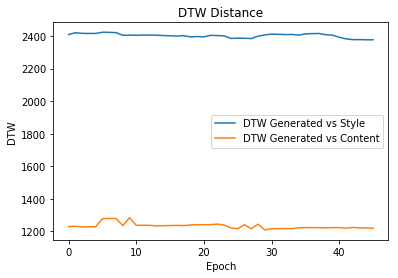

Start of iteration 96
Total loss: 4.296566009521484
Iteration 96 completed in 0s


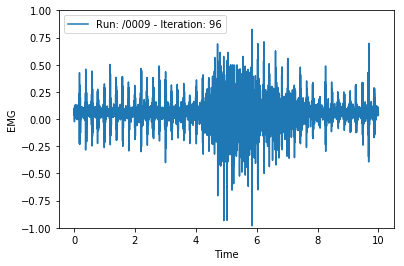

Metrics - Content CC:[161.83709491], FFT:159.76632328841933, DTW:1219.3719025693508
Metrics - Style CC:[-32.37835067], FFT:112.4957169959438, DTW:2377.9480472395176


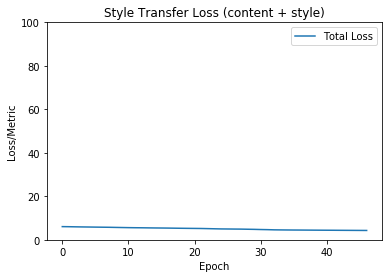

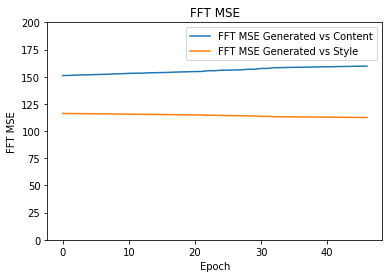

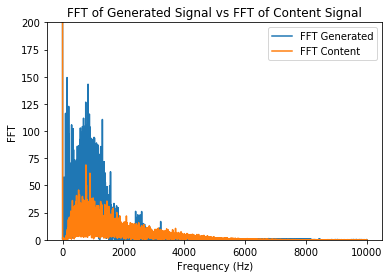

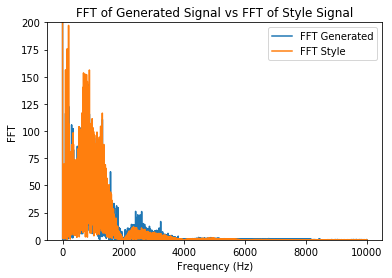

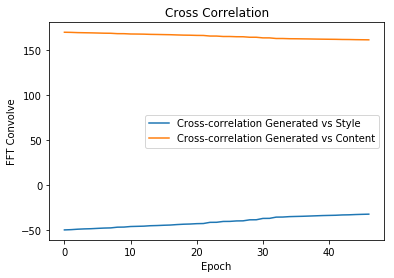

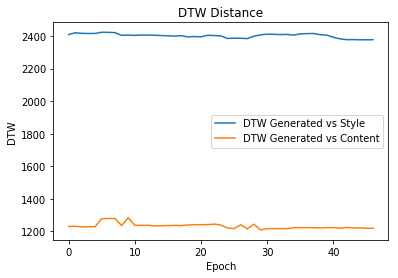

Start of iteration 97
Total loss: 4.283243179321289
Iteration 97 completed in 0s


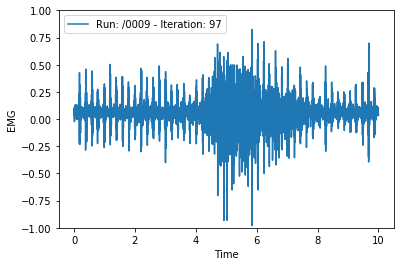

Metrics - Content CC:[161.76303142], FFT:159.83243267241306, DTW:1219.4019362588099
Metrics - Style CC:[-32.20004677], FFT:112.45265240613114, DTW:2378.1297032756247


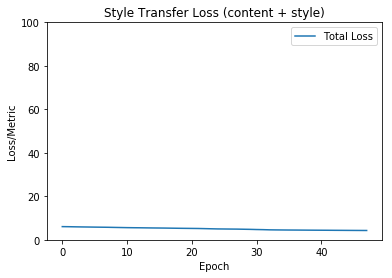

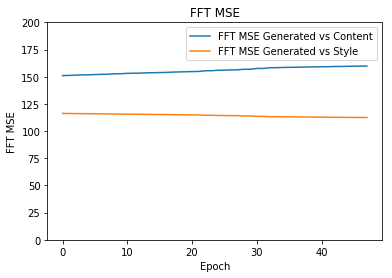

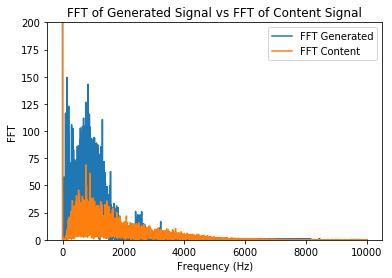

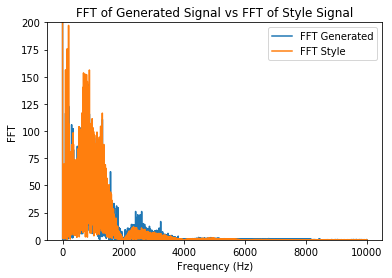

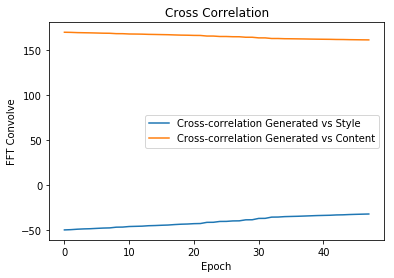

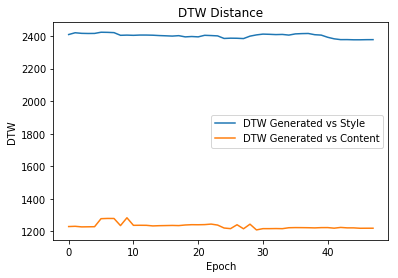

Start of iteration 98
Total loss: 4.267021656036377
Iteration 98 completed in 0s


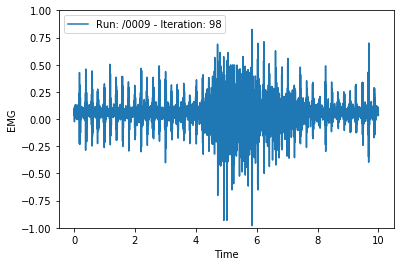

Metrics - Content CC:[161.66054961], FFT:159.9366266688374, DTW:1213.1479635994322
Metrics - Style CC:[-31.98098218], FFT:112.40608766994185, DTW:2378.4493595099643


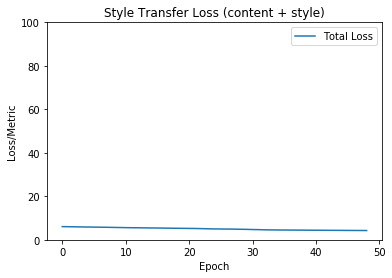

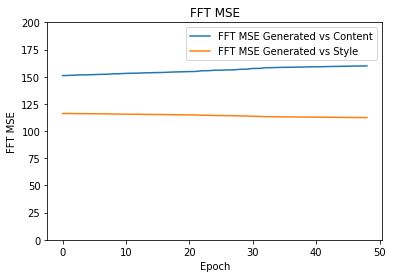

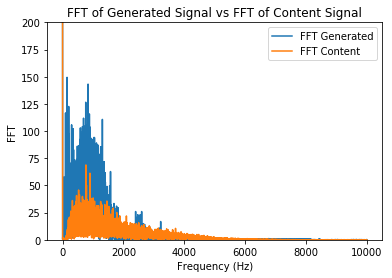

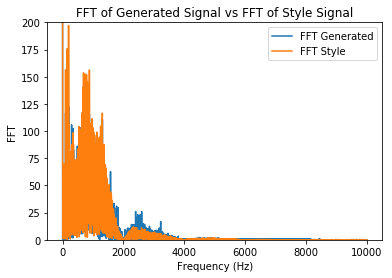

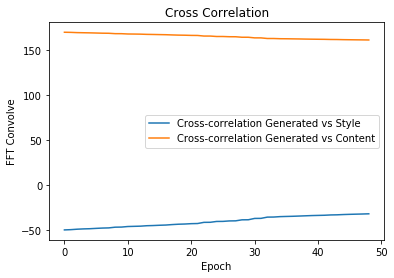

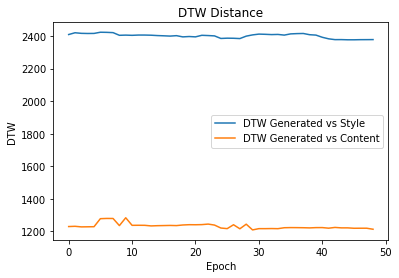

Start of iteration 99
Total loss: 4.253546714782715
Iteration 99 completed in 0s


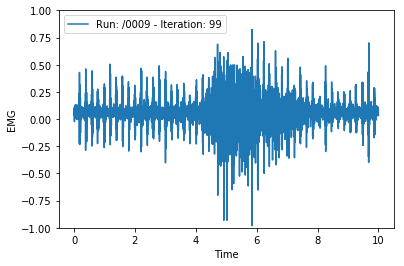

Metrics - Content CC:[161.58435986], FFT:160.01970259018373, DTW:1212.9232207418504
Metrics - Style CC:[-31.79227469], FFT:112.36119133733656, DTW:2378.7832901890692


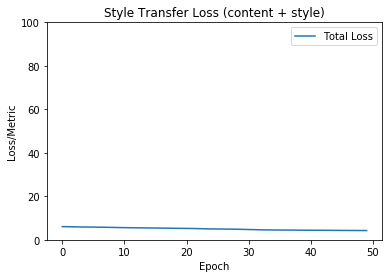

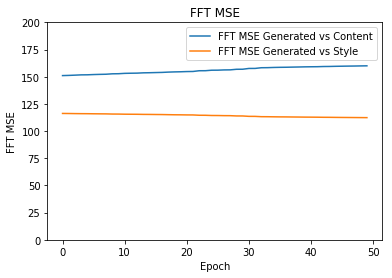

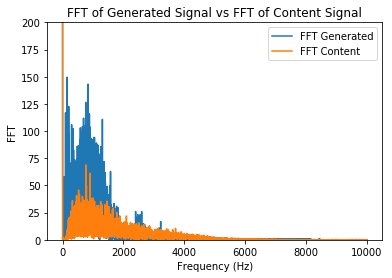

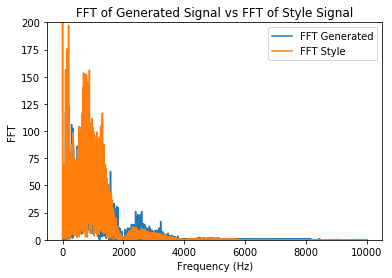

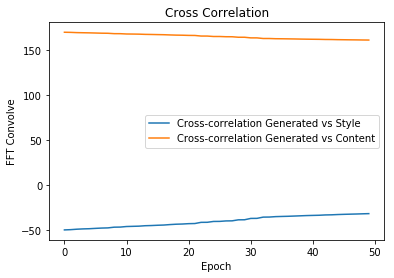

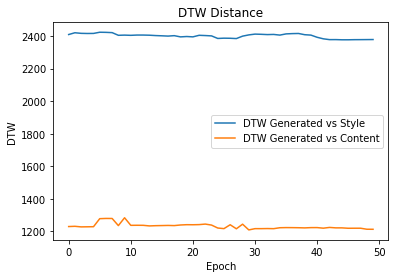

In [50]:
import time
#metrics = []
for i in range(0+50,50+iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=10)
    print('Total loss: {}'.format(min_val))
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    np.savetxt(path + "{0}/{1}_output.csv".format(run_id,i), x, delimiter=",")
    plot_signal(x, 'Run: {0} - Iteration: {1}'.format(run_id,i), "{}_output.png".format(i))
    
    #Calculate current metrics
    content_flat = content_array.flatten()
    style_flat = style_array.flatten()
    cc_metric = cross_correlation(content_flat, x)
    sc_metric = cross_correlation(style_flat, x)
    content_dtw_distance = dtw_distance(content_flat, x)
    style_dtw_distance = dtw_distance(style_flat, x)
    fft_metric_content, fft_content, fft_generated = loss_fft(content_flat, x)
    fft_metric_style, fft_style, _ = loss_fft(style_flat, x)
    content_style_convolve = signal.convolve(content_flat, style_flat, mode='full')
    generated_style_convolve = signal.convolve(x, style_flat, mode='full')
    generated_content_convolve = signal.convolve(x, content_flat, mode='full')
    ffts = [fft_content, fft_style, fft_generated, content_style_convolve, generated_style_convolve, generated_content_convolve]
    print('Metrics - Content CC:{}, FFT:{}, DTW:{}'.format(cc_metric,fft_metric_content,content_dtw_distance))
    print('Metrics - Style CC:{}, FFT:{}, DTW:{}'.format(sc_metric,fft_metric_style,style_dtw_distance))
    
    metrics.append([[min_val],[cc_metric],[fft_metric_content],[content_dtw_distance],[sc_metric],[fft_metric_style],[style_dtw_distance]])
    
    plot_metrics(i, metrics, ffts)

In [ ]:
print
x_backup = x
x.shape

In [ ]:
metrics_np = np.array(metrics)

In [ ]:
metrics_np[:,2]

Loaded data shape: (20000, 1)


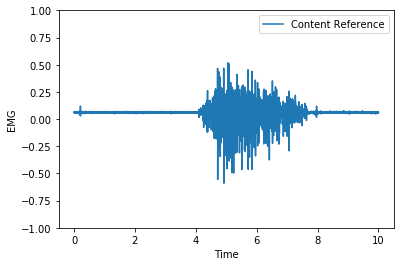

In [14]:
#Plot content as reference
content_image = load_content()
#content_image_reshaped = content_image.reshape((height * width, 3))
plot_signal(content_image, 'Content Reference', "content.png")

Loaded data shape: (20000, 1)


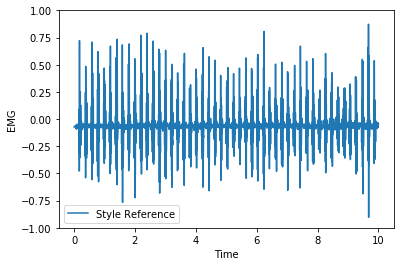

In [13]:
#Plot style as reference
style_image = load_style()
#style_image_reshaped = style_image.reshape((height * width, 3))
plot_signal(style_image, 'Style Reference', "style.png")

In [ ]:
#Plot final result
plot_signal(x, 'Run: {0} - Final generated signal'.format(run_id), "output.png".format(run_id))

In [ ]:
#model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
critic_model = build_critic(-1)
file_path = path + '/critic.h5'
critic_model.load_weights(file_path)

In [ ]:
x_reshaped=np.reshape(x,(20,2000,1))
critic_results = critic_model.predict(x_reshaped)

In [ ]:
#Plot the results with respect to the discriminator model
x_reshaped=np.reshape(x,(20,2000))
for i in range(0,20):
    split = x_reshaped[i,:]
    critic_result = critic_results[i]
    plot_signal(split, 'Split: {0} - Critic: {1}'.format(i,critic_result), "{0}/x_reshaped_{1}.png".format(run_id,i))

In [26]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
def dtw_distance(y_true, y_pred):        
    y_true_reshaped = np.reshape(y_true, (y_true.shape[0]*y_true.shape[1]))
    y_pred_reshaped = np.reshape(y_pred, (y_pred.shape[0]*y_pred.shape[1]))
    distance = dtw.distance(y_true_reshaped, y_pred_reshaped)
    return distance

def dtw_plot_distance(y_true, y_pred, filename):        
    y_true_reshaped = np.reshape(y_true, (y_true.shape[0]*y_true.shape[1]))
    y_pred_reshaped = np.reshape(y_pred, (y_pred.shape[0]))
    s1 = np.array(y_true_reshaped)
    s2 = np.array(y_pred_reshaped)
    path = dtw.warping_path(s1, s2)
    dtwvis.plot_warping(s1, s2, path, filename=filename)

def loss_fft(y_true, y_pred):        
    fft_true = np.abs(np.fft.rfft(y_true))
    #print('FFT Shape: {}'.format(fft_true.shape))
    fft_pred = np.abs(np.fft.rfft(y_pred))
    #print('FFT Shape: {}'.format(fft_pred.shape))
    loss = np.mean(np.square(np.subtract(fft_true,fft_pred))) #calculate mse from fft
    #print('FFT Shape: {}'.format(loss.shape))
    #fft_all = np.concatenate((fft_true,fft_pred,loss),axis=0)
    return loss, fft_true, fft_pred

def cross_correlation(y_true, y_pred):
    cc = np.correlate(y_true,y_pred)
    return cc

def dtw_distance(y_true, y_pred):        
    #distance = dtw.distance(y_true, y_pred)
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    return distance   

In [27]:
dtwd = dtw_plot_distance(style_image, content_image, path + 'contet_style_dtw.png')

In [ ]:
dtw_distancef_fast